# How do economic fluctuations influence job satisfaction among employees in Spain?


# Dataset Information

The dataset is from the **European Social Survey**, from round 10, with respect to the year 2020. We filtered the country to be **Spain**. The main categories from each of the data to build the explanatory variables include:  
1. Media use and trust  
2. Politics  
3. Subjective well-being and social exclusion  
4. Gender, age and household composition  
5. Socio-demographic profile, Family, work and wellbeing and Personal and social well-being.  

The dependent variable under analysis belongs to the category Personal and Social Well-being, and can be described as _‘How satisfied are you in your main job’_.

The dependent variable uses a score from 0 to 10 with 0 being 'Extremely dissatisfied' and 10 being 'Extremely satisfied'. Since the focus of the class was **Binary Regression**, we transform our dependent using mean, and median (respectively) for the cutoff, to be binary: **satisfied and not satisfied.**



# Importing packages

In [ ]:
!pip install jenkspy
!pip install xlsxwriter

In [ ]:
# To clear all variables
# from IPython import get_ipython
# get_ipython().magic('reset -sf')

import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
import statsmodels.api as sm
import os
from sklearn.model_selection import train_test_split
import seaborn as sns

import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from scipy.stats._stats import _kendall_dis

from jenkspy import JenksNaturalBreaks

import plotly.graph_objects as go

from bs4 import BeautifulSoup
import html5lib
import json
import re
import string

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

import xlsxwriter
import time



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data_folder = '/content'

### Custom Functions

In [ ]:

def responseprofile(y):
    ydf = pd.DataFrame(y)
    ydf.columns = ['y']
    tata=pd.crosstab(index=ydf['y'], columns='count')
    tata[['count']]
    tata.index.name = 'values'
    tata.reset_index(inplace=True)
    the_table=pd.DataFrame(data=tata)
    the_table.columns = ['Values (y)' , 'Total Frequency']
    plt.subplot(212)
    plt.title('Response Profile',fontsize=20,y=1.7)
    plt.axis('off')
    plt.axis('tight')
    test2=plt.table(cellText=the_table.values, loc='center', cellLoc='center', colLabels=the_table.columns, colWidths=[0.4,0.4])
    test2.auto_set_font_size(False)
    test2.set_fontsize(16)
    test2.scale(2, 1.7)

def convergence(y,logit_res):
    val_listsetting = list(logit_res.mle_settings.values())
    val_listretvals = list(logit_res.mle_retvals.values())
    the_table2 = [ ['Optimizer',val_listsetting[0] ] ,
                      ['Starting parameters', val_listsetting[1]],
                      ['Max. iterations', val_listsetting[2]],
                      ['Tolerance rate', val_listsetting[9]],
                      ['Req. iterations', val_listretvals[1]],
                      ['Convergence Status', val_listretvals[5]]]
    the_table2=pd.DataFrame(data=the_table2)
    plt.subplot(212)
    plt.title('Model Convergence Status',fontsize=20,y=1.2)
    plt.axis('off')
    plt.axis('tight')
    test2=plt.table(cellText=the_table2.values, loc='center', cellLoc='center', colWidths=[0.4,0.4,0.4])
    test2.auto_set_font_size(False)
    test2.set_fontsize(16)
    test2.scale(2, 1.7)

def informationcriteria(y,logit_res):
    the_table3 = [['AIC', np.round(-2*(logit_res.llnull-1),3),np.round(logit_res.aic,3)],
                      ['BIC', np.round(-2*logit_res.llnull+np.log(logit_res.nobs),3),np.round(logit_res.bic,3)],
                      ['-2LogL', np.round(-2*logit_res.llnull,3),np.round(-2*logit_res.llf,3)]]
    the_table3=pd.DataFrame(data=the_table3)
    the_table3.columns = ['Criterion', 'Intercept Only', 'Intercept and Covariates']
    plt.subplot(311)
    plt.title('Information Criteria',fontsize=20, y=1.1)
    plt.axis('off')
    plt.axis('tight')
    test3=plt.table(cellText=the_table3.values, colLabels=the_table3.columns, loc='center', cellLoc='center', colWidths=[0.4,0.4,0.4])
    test3.auto_set_font_size(False)
    test3.set_fontsize(16)
    test3.scale(2, 1.7)

def globalnull(y,logit_res):
    M = np.identity(len(logit_res.params))
    M = M[1:,:]
    wald_global = logit_res.wald_test(M,scalar=False)

    globalnull = [['Likelihood Ratio Test',round(logit_res.llr,4),round(logit_res.df_model),round(logit_res.llr_pvalue,5)],
                 ['Wald',round(wald_global.statistic.item(),4), round(logit_res.df_model),round(wald_global.pvalue.item(),5)]]
    globalnull=pd.DataFrame(data=globalnull)
    globalnull.columns = ['Test','Chi-Square','DF','Pr>ChiSq' ]
    plt.subplot(312)
    plt.title('Testing Global Null Hypothesis: BETA=0',fontsize=20)
    plt.axis('off')
    plt.axis('tight')
    test=plt.table(cellText=globalnull.values, colLabels=globalnull.columns,
                   loc='center', cellLoc='center', colWidths=[0.3,0.2,0.2,0.2])
    test.auto_set_font_size(False)
    test.set_fontsize(18)
    test.scale(2, 1.7)

def oddsratioestimates(y,logit_res):
    freqy=y.value_counts()
    m=len(freqy)
    params = logit_res.params[1:len(logit_res.params)]
    conf = logit_res.conf_int()
    conf=conf.iloc[1:len(logit_res.params)]
    confodr=np.exp(conf)
    odr=np.exp(params.to_frame())
    odr=odr.rename(columns={0:'Point Estimate'})
    confodr=confodr.rename(columns={0:'5%', 1:'95%'})
    table=pd.concat([odr[['Point Estimate']], confodr[['5%','95%']]], axis=1)
    plt.subplot(313)
    plt.title('Odds Ratio Estimates',fontsize=20,y=1.4)
    plt.axis('off')
    plt.axis('tight')
    table.update(table.astype(float))
    table.update(table.applymap('{:,.3f}'.format))
    test=plt.table(cellText=table.values, colLabels=['Point Estimate', 'Lower CI (95% Wald)','Upper CI (95% Wald)'],
                   rowLabels=table.index, loc='center',cellLoc='center',colWidths=[0.3,0.35,0.35])
    plt.axis('off')
    test.auto_set_font_size(False)
    test.set_fontsize(20)
    test.scale(2, 1.7)
    print('!!ATTENTION: Odds ratio are only OK with the Logit link function!!')

def associationstat(X, y, logit_res):

    Xmat = np.array(X)
    ymat=np.array(y)
    beta_hat=np.array(logit_res.params)
    #print(np.shape(Xmat))
    #print(np.shape(beta_hat))
    score_hat=Xmat.dot(beta_hat)
    x=score_hat

    freqy=y.value_counts()
    total=freqy.iloc[0]*freqy.iloc[1]

    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()

    if x.size != y.size:
        raise ValueError("All inputs must be of the same size, "
                         "found x-size %s and y-size %s" % (x.size, y.size))

    def count_rank_tie(ranks):
        cnt = np.bincount(ranks).astype('int64', copy=False)
        cnt = cnt[cnt > 1]
        return ((cnt * (cnt - 1) // 2).sum(),
            (cnt * (cnt - 1.) * (cnt - 2)).sum(),
            (cnt * (cnt - 1.) * (2*cnt + 5)).sum())

    size = x.size
    perm = np.argsort(y)  # sort on y and convert y to dense ranks
    x, y = x[perm], y[perm]
    y = np.r_[True, y[1:] != y[:-1]].cumsum(dtype=np.intp)

    # stable sort on x and convert x to dense ranks
    perm = np.argsort(x, kind='mergesort')
    x, y = x[perm], y[perm]
    x = np.r_[True, x[1:] != x[:-1]].cumsum(dtype=np.intp)

    nd = _kendall_dis(x, y)  # discordant pairs

    obs = np.r_[True, (x[1:] != x[:-1]) | (y[1:] != y[:-1]), True]
    cnt = np.diff(np.where(obs)[0]).astype('int64', copy=False)

    ntie = (cnt * (cnt - 1) // 2).sum()  # joint ties
    xtie, x0, x1 = count_rank_tie(x)     # ties in x, stats
    ytie, y0, y1 = count_rank_tie(y)     # ties in y, stats

    tot = (size * (size - 1)) // 2

    nc = tot - nd - (xtie - ntie) - (ytie - ntie) - ntie

    #return (nc,nd,ntie,total)
    #nc, nd, ntie, total = AssociationStat(x, y)

    the_table = [ ['Percent Concordant',round(nc/total*100,2), 'Somers D',round((nc-nd)/total,3)],
                      ['Percent Discordant', round(nd/total*100,2), 'Gamma',round((nc-nd)/(nc+nd),3)],
                      ['Percent Tied', round((total-nc-nd)/total*100,2), 'Tau-a', round((nc-nd)/(0.5*y.size*(y.size-1)),3)],
                      ['Pairs', round(total),'c',round((nc+0.5*(total-nc-nd))/total,3)]]
    the_table=pd.DataFrame(data=the_table)
    plt.subplot(221)
    plt.title('Association of Predicted Probabilities and Observed Responses',fontsize=20,y=0.95)
    plt.axis('off')
    plt.axis('tight')
    test=plt.table(cellText=the_table.values, loc='center', cellLoc='center', colWidths=[0.8,0.4,0.4,0.4,0.4])
    test.auto_set_font_size(False)
    test.set_fontsize(20)
    test.scale(2, 1.7)


def performancemetrics(y_test, pi_test, gamma):
    # Calculate predictions based on gamma threshold
    y_hatnp = np.where(pi_test > gamma, 1, 0)
    y_hat = pd.DataFrame(y_hatnp, columns=['y_hat'])

    # Convert y_test to DataFrame for consistency in handling
    y_laby = pd.DataFrame(y_test).reset_index(drop=True)
    y_laby.columns = ['y']

    # Concatenate true labels and predictions for confusion matrix
    yyhat = pd.concat([y_laby, y_hat], axis=1)

    # Confusion matrix
    confusion_matrix = pd.crosstab(yyhat.y, yyhat.y_hat, margins=True)
    print(confusion_matrix)

    # ROC curve and AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pi_test, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)

    # Find optimal threshold index
    optimal_idx = np.argmax(tpr - fpr)

    # Plotting ROC curve including the optimal threshold
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label='Optimal Threshold')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC
    print('AUC: %.4f' % roc_auc)

    # Calculate and print R2 Efron
    ynp = np.asarray(y_test).ravel()
    pinp = np.asarray(pi_test).ravel()
    R2Efron = 1 - np.sum((ynp - pinp) ** 2) / np.sum((ynp - np.mean(ynp)) ** 2)
    print('R2 Efron:', R2Efron)

    # Calculate and print the number of prediction errors and percentage of correctly classified instances
    nberrors = np.sum((ynp - y_hatnp) ** 2)
    print('gamma:', gamma, '- number of predictions errors:', nberrors, '- percentage of correctly classified: %.4f' % (1 - nberrors / len(ynp)))

# Importing the Dataset

We need to upload the following files in the `Files` section of Colab before running the below cells -

1. Full Dataset - Spain - Variable Selection - Stage 1 - FINAL.csv

    (The output of the previous notebook)

2. Full Dataset - Spain.html

In [ ]:
data = pd.read_csv('/content/Full Dataset - Spain - Variable Selection - Stage 1 - FINAL.csv')
display(data.head())

How emotionally attached to [country]  Born in country  Citizen of country  \
0                                   10.0              1.0                 1.0   
1                                    9.0              1.0                 1.0   
2                                    9.0              1.0                 1.0   
3                                    9.0              1.0                 1.0   
4                                   10.0              1.0                 1.0   

   How happy are you  Subjective general health  \
0                9.0                        3.0   
1                2.0                        4.0   
2                8.0                        3.0   
3                9.0                        1.0   
4               10.0                        1.0   

   Hampered in daily activities by illness/disability/infirmity/mental problem  \
0                                                3.0                             
1                                                1.0                             
2                                                3.0                             
3                                                3.0                             
4                                                3.0                             

   How many people with whom you can discuss intimate and personal matters  \
0                                                5.0                         
1                                                1.0                         
2                                                1.0                         
3                                                3.0                         
4                                                2.0                         

   How religious are you  \
0                    9.0   
1                    8.0   
2                    0.0   
3                    0.0   
4                    6.0   

   Take part in social activities compared to others of same age  \
0                                                4.0               
1                                                1.0               
2                                                2.0               
3                                                1.0               
4                                                4.0               

   How often socially meet with friends, relatives or colleagues  ...  \
0                                                6.0              ...   
1                                                2.0              ...   
2                                                4.0              ...   
3                                                7.0              ...   
4                                                7.0              ...   

   Communicate with colleagues about work via text, email or messaging apps, how often  \
0                                                1.0                                     
1                                                3.0                                     
2                                                4.0                                     
3                                                3.0                                     
4                                                1.0                                     

   Speak with colleagues about work and see each other on a screen, how often  \
0                                                3.0                            
1                                                6.0                            
2                                                7.0                            
3                                                7.0                            
4                                                7.0                            

   Speak with colleagues about work using a phone, how often  \
0                                                1.0           
1                                                3.0           
2         

In [ ]:
old_columns = data.columns
stopwords_en = stopwords.words('english')
stopwords_en.remove('not')
old_columns_no_stopwords = ['_'.join(c for c in s.split() if c not in stopwords_en) for s in old_columns]
old_columns_lower_case = [i.lower().replace("/", "_").replace("__", "/") for i in old_columns_no_stopwords]
old_columns_lower_case_without_special_chars = [ re.sub(r'[^a-z_]', '', x) for x in old_columns_lower_case]

# Creating a dictionary mapping original column names to new column names

new_column_names = old_columns_lower_case_without_special_chars

rename_dict = dict(zip(data.columns, new_column_names))

# Rename the columns
data.rename(columns=rename_dict, inplace=True)
data.head()

how_emotionally_attached_country  born_country  citizen_country  how_happy  \
0                              10.0           1.0              1.0        9.0   
1                               9.0           1.0              1.0        2.0   
2                               9.0           1.0              1.0        8.0   
3                               9.0           1.0              1.0        9.0   
4                              10.0           1.0              1.0       10.0   

   subjective_general_health  \
0                        3.0   
1                        4.0   
2                        3.0   
3                        1.0   
4                        1.0   

   hampered_daily_activities_illness_disability_infirmity_mental_problem  \
0                                                3.0                       
1                                                1.0                       
2                                                3.0                       
3                                                3.0                       
4                                                3.0                       

   how_many_people_discuss_intimate_personal_matters  how_religious  \
0                                                5.0            9.0   
1                                                1.0            8.0   
2                                                1.0            0.0   
3                                                3.0            0.0   
4                                                2.0            6.0   

   take_part_social_activities_compared_others_age  \
0                                              4.0   
1                                              1.0   
2                                              2.0   
3                                              1.0   
4                                              4.0   

   how_often_socially_meet_friends_relatives_colleagues  ...  \
0                                                6.0     ...   
1                                                2.0     ...   
2                                                4.0     ...   
3                                                7.0     ...   
4                                                7.0     ...   

   communicate_colleagues_work_via_text_email_messaging_apps_often  \
0                                                1.0                 
1                                                3.0                 
2                                                4.0                 
3                                                3.0                 
4                                                1.0                 

   speak_colleagues_work_see_screen_often  \
0                                     3.0   
1                                     6.0   
2                                     7.0   
3                                     7.0   
4                                     7.0   

   speak_colleagues_work_using_phone_often  \
0                                      1.0   
1                                      3.0   
2                                      3.0   
3                                      7.0   
4                                      1.0   

   too_tired_work_enjoy_things_like_home_often  \
0                                          3.0   
1                                          5.0   
2                                          4.0   
3                                          2.0   
4                                          1.0   

   job_prevents_giving_time_partner_family_often  \
0                                            2.0   
1                                            4.0   
2                                            4.0   
3                                            2.0   
4                                            1.0   

   partner_family_fed_pressure_job_often  \
0                                    2.0   
1                                    4.0   
2             

### Category Mapping from HTML File

In [ ]:
dataset_columns = data.columns.to_list()

stopwords_en = stopwords.words('english')
stopwords_en.remove('not')

html_file = os.path.join(data_folder, 'Full Dataset - Spain.html')

myFile= open(html_file,encoding="utf8")
soup = BeautifulSoup(myFile.read(), features='html')

variable_names = soup.find_all('div', class_=not('data-table'))

variable_category_mapping = {}

for variable in variable_names:

    if variable.find('div', class_=not('data-table')) != None:
        name = variable.find('div', class_=not('data-table')).text
        name = '_'.join(c for c in name.split() if c not in stopwords_en)
        name = name.lower().replace("/", "_").replace("__", "/")
        name = re.sub(r'[^a-z_]', '', name)

        category_mapping = {}

        if name in dataset_columns:
            data_table = variable.find('div', class_='data-table').find('table').find('tbody').find_all('tr')

            for row in data_table:
                id = row.find_all('td')[0].text

                value = row.find_all('td')[1].text.encode("ascii", "ignore").decode()

                category_mapping[id]= id + "_" + value

            variable_category_mapping[name] = category_mapping

json.dump(variable_category_mapping, open(os.path.join(data_folder, 'Variables - Category mapping.json'), 'w'))

### Data File Understandability

Changing the column names and the values to be more intuitive

In [ ]:
## To load the json data
import math

variable_category_mapping = json.load(open(os.path.join(data_folder, 'Variables - Category mapping.json'), 'r'))

for column in data.columns:

    if column != 'how_satisfied_main_job':
        new_column = []
        for i in data[column]:
            if type(i) == float or type(i) == int:
                if math.isnan(i):
                    new_column.append(i)
                    continue
            try:
                if str(int(i)) not in variable_category_mapping[column].keys():
                    new_column.append(i)
                else:
                    new_column.append(variable_category_mapping[column][str(int(i))])
            except:
                if str(i) not in variable_category_mapping[column].keys():
                    new_column.append(i)
                else:
                    new_column.append(variable_category_mapping[column][str(i)])

        data[column] = new_column

display(data.head())

how_emotionally_attached_country born_country citizen_country  \
0     10_Very emotionally attached        1_Yes           1_Yes   
1                              9_9        1_Yes           1_Yes   
2                              9_9        1_Yes           1_Yes   
3                              9_9        1_Yes           1_Yes   
4     10_Very emotionally attached        1_Yes           1_Yes   

            how_happy subjective_general_health  \
0                 9_9                    3_Fair   
1                 2_2                     4_Bad   
2                 8_8                    3_Fair   
3                 9_9               1_Very good   
4  10_Extremely happy               1_Very good   

  hampered_daily_activities_illness_disability_infirmity_mental_problem  \
0                                               3_No                      
1                                        1_Yes a lot                      
2                                               3_No                      
3                                               3_No                      
4                                               3_No                      

  how_many_people_discuss_intimate_personal_matters           how_religious  \
0                                             5_7-9                     9_9   
1                                               1_1                     8_8   
2                                               1_1  0_Not at all religious   
3                                               3_3  0_Not at all religious   
4                                               2_2                     6_6   

  take_part_social_activities_compared_others_age  \
0                                4_More than most   
1                           1_Much less than most   
2                                2_Less than most   
3                           1_Much less than most   
4                                4_More than most   

  how_often_socially_meet_friends_relatives_colleagues  ...  \
0                             6_Several times a week    ...   
1                           2_Less than once a month    ...   
2                            4_Several times a month    ...   
3                                        7_Every day    ...   
4                                        7_Every day    ...   

   communicate_colleagues_work_via_text_email_messaging_apps_often  \
0                              1_Several times a day                 
1                             3_Several times a week                 
2                            4_Several times a month                 
3                             3_Several times a week                 
4                              1_Several times a day                 

  speak_colleagues_work_see_screen_often  \
0                 3_Several times a week   
1                           6_Less often   
2                                7_Never   
3                                7_Never   
4                                7_Never   

   speak_colleagues_work_using_phone_often  \
0                    1_Several times a day   
1                   3_Several times a week   
2                   3_Several times a week   
3                                  7_Never   
4                    1_Several times a day   

   too_tired_work_enjoy_things_like_home_often  \
0                                  3_Sometimes   
1                                     5_Always   
2                                      4_Often   
3                                2_Hardly ever   
4                                      1_Never   

  job_prevents_giving_time_partner_family_often  \
0                                 2_Hardly ever   
1                                       4_Often   
2                                       4_Often   
3                                 2_Hardly ever   
4                                       1_Never   

  partner_family_fed_pressure_job_often  \
0                         2_Hardly ever   
1          

# (1).  Explanatory Data Analysis and Data Preparation

## 1.1 Explanatory Data Analysis

### Identifying Variable Types and Visualising

#### (a). Numeric Features

Before removal of outliers


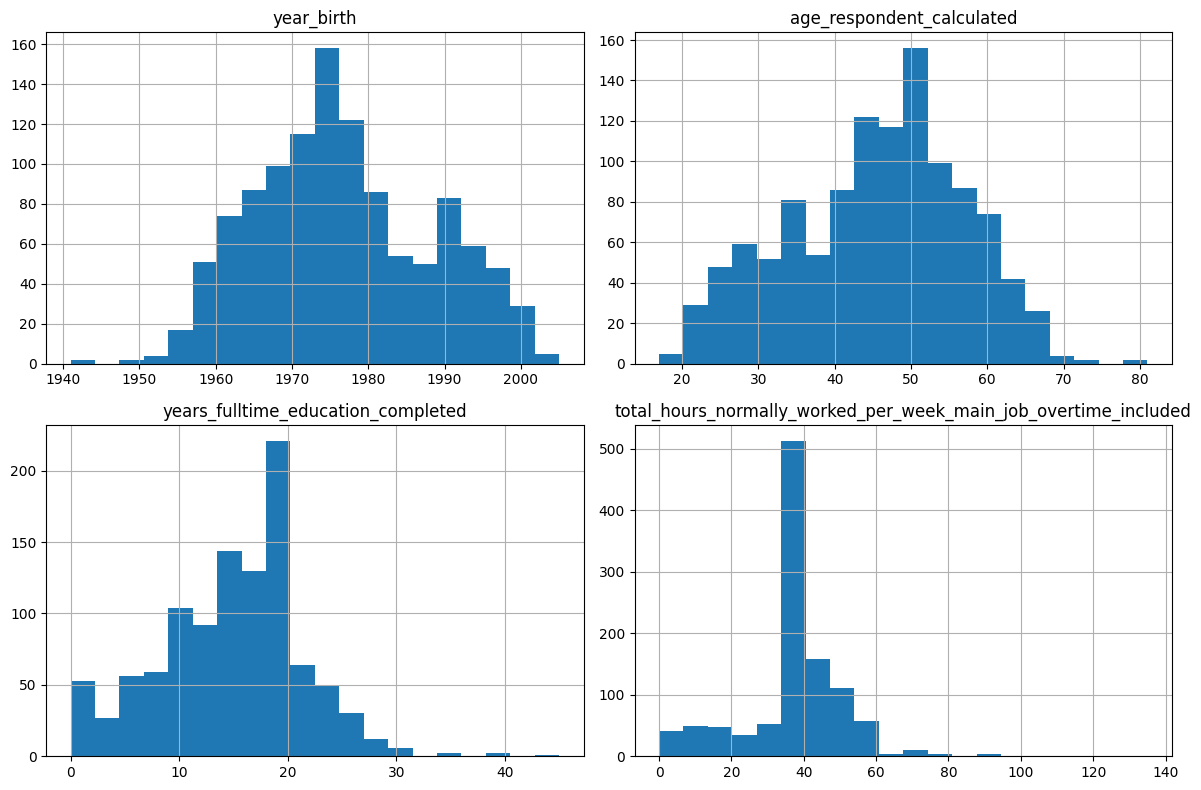

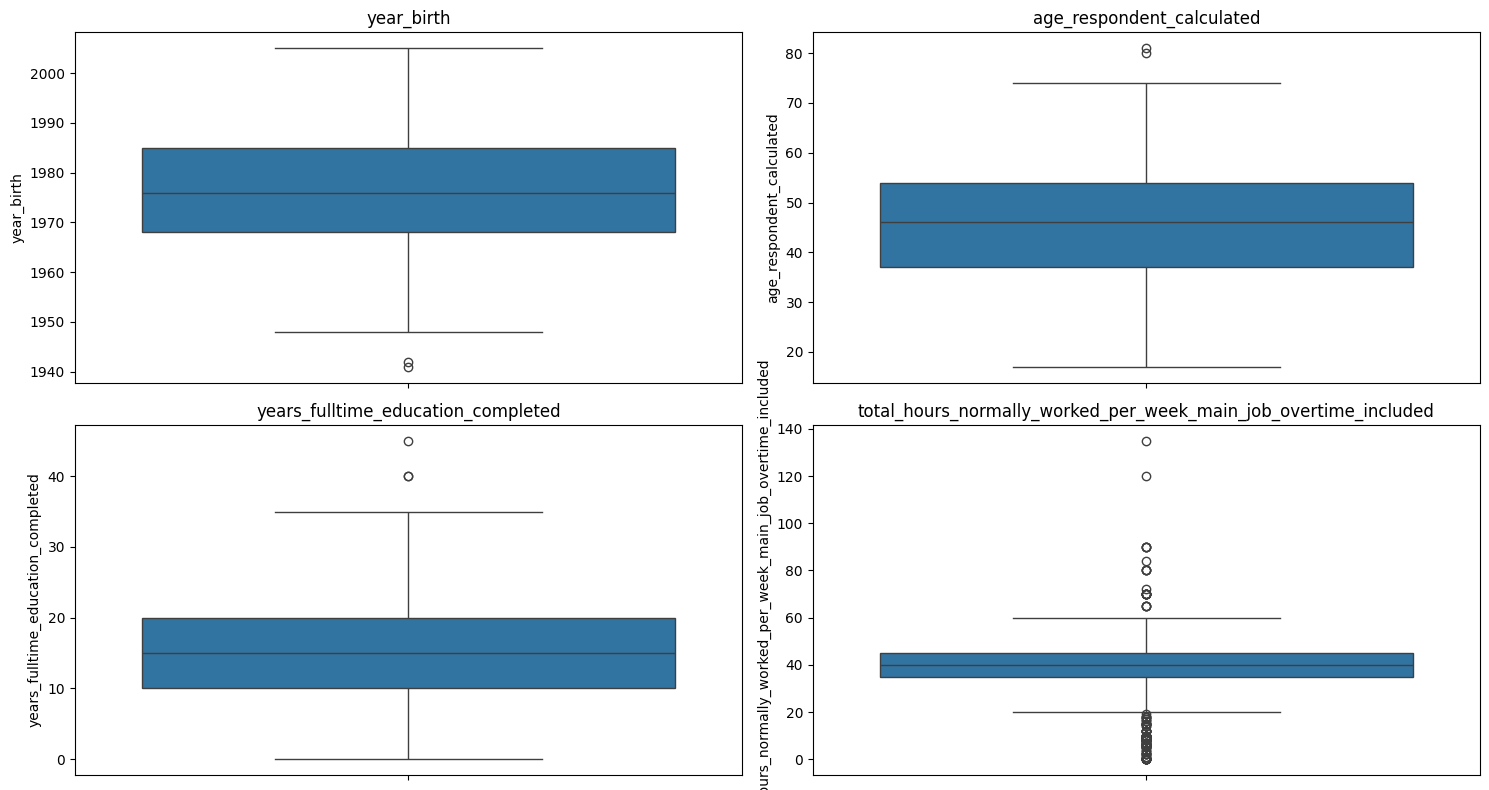

After removal of outliers


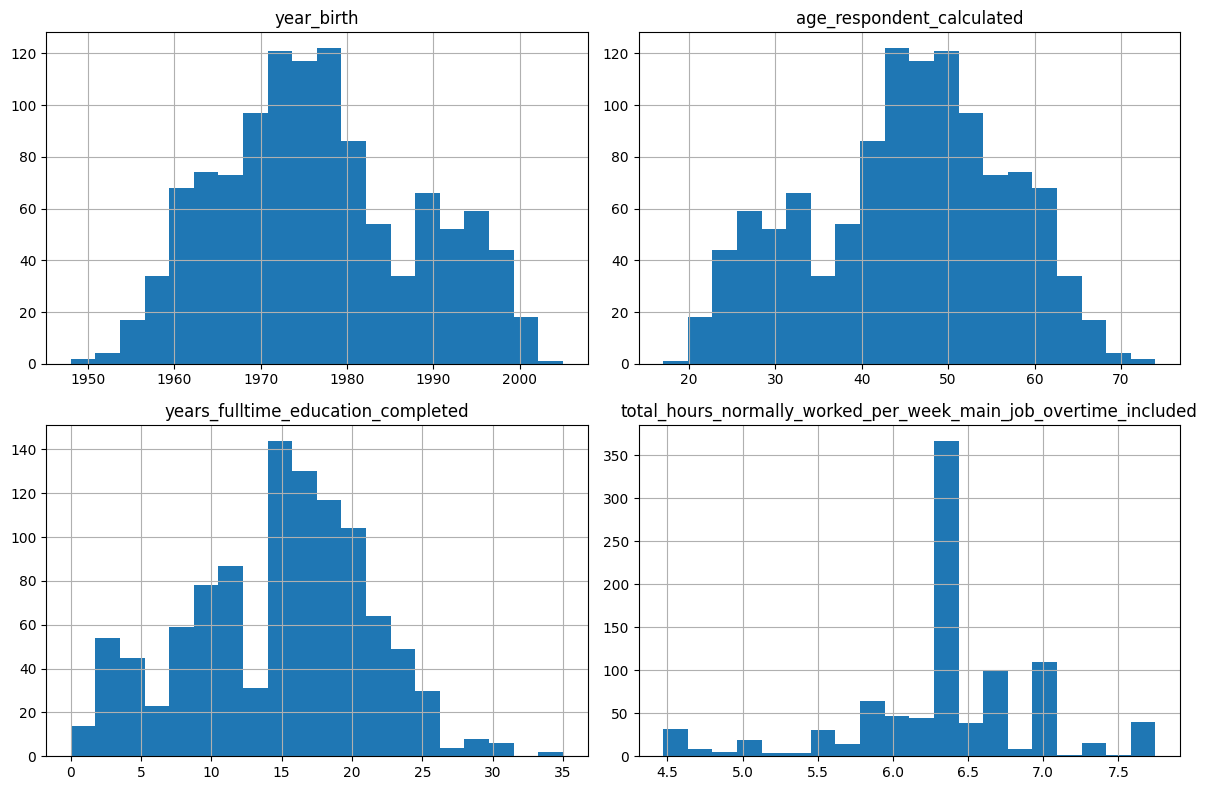

In [ ]:
# Group Numeric Covariates
numerical_features = ['year_birth',
                      'age_respondent_calculated',
                      'years_fulltime_education_completed',
                      'total_hours_normally_worked_per_week_main_job_overtime_included']

X_numeric = data[numerical_features]

## Descriptive statistics before outlier removal

print("Before removal of outliers")
plt.figure(figsize=(12, 8))

for i, column in enumerate(X_numeric.columns):
    plt.subplot(2, 2, i + 1)
    X_numeric[column].hist(bins=20)
    plt.title(column)

plt.subplots_adjust(hspace=1)
plt.tight_layout()
plt.show()

print("="*50)

## Replace outliers with 'nan'

plt.figure(figsize=(15, 8))

for i, column in enumerate(X_numeric.columns):

    plt.subplot(2, 2, i + 1)
    sns.boxplot(X_numeric[column])
    plt.title(column)

    Q1 = X_numeric[column].quantile(0.25)
    Q3 = X_numeric[column].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range.

    filter = (X_numeric[column] >= Q1 - 1.5 * IQR) & (X_numeric[column] <= Q3 + 1.5 *IQR)

    if column == 'total_hours_normally_worked_per_week_main_job_overtime_included':

        X_numeric[column] = np.where(filter, np.sqrt(X_numeric[column]), np.nan)
    else:
        X_numeric[column] = np.where(filter, X_numeric[column], np.nan)


plt.subplots_adjust(hspace=1)
plt.tight_layout()
plt.show()


print("After removal of outliers")

plt.figure(figsize=(12, 8))

for i, column in enumerate(X_numeric.columns):
    plt.subplot(2, 2, i + 1)
    X_numeric[column].hist(bins=20)
    plt.title(column)

plt.subplots_adjust(hspace=1)
plt.tight_layout()
plt.show()

In [ ]:
## Numeric Covariates: Missing Values
stats_numeric = X_numeric.describe(include = 'all')
miss_numeric=(data.shape[0]-stats_numeric.iloc[0])/data.shape[0]*100
stats_numeric.loc['% missing'] = miss_numeric
stats_numeric

year_birth  age_respondent_calculated  \
count      1143.000000                1143.000000   
mean       1976.661417                  45.338583   
std          11.473871                  11.473871   
min        1948.000000                  17.000000   
25%        1968.000000                  37.000000   
50%        1976.000000                  46.000000   
75%        1985.000000                  54.000000   
max        2005.000000                  74.000000   
% missing     0.261780                   0.261780   

           years_fulltime_education_completed  \
count                             1049.000000   
mean                                14.734986   
std                                  6.371777   
min                                  0.000000   
25%                                 10.000000   
50%                                 15.000000   
75%                                 20.000000   
max                                 35.000000   
% missing                            8.464223   

           total_hours_normally_worked_per_week_main_job_overtime_included  
count                                             958.000000                
mean                                                6.337700                
std                                                 0.649370                
min                                                 4.472136                
25%                                                 6.164414                
50%                                                 6.324555                
75%                                                 6.708204                
max                                                 7.745967                
% missing                                          16.404887

In [ ]:
# Group Nominal Covariates

nominal_features = ['born_country',
                  'citizen_country',
                  'gender',
                  'improve_knowledge_skills_course_lecture_conference_last__months',
                  'doing_last__days_permanently_sick_disabled',
                  'partner_last__days_permanently_sick_disabled',
                  'ever_divorced_had_civil_union_dissolved',
                  'doing_last__days_education',
                  'partner_last__days_education',
                  'main_source_household_income',
                  'doing_last__days_housework_looking_children_others',
                  'partner_last__days_housework_looking_children_others',
                  'occupation_isco',
                  'responsible_supervising_employees',
                  'fathers_occupation_respondent_',
                  'doing_last__days_paid_work',
                  'partner_last__days_paid_work',
                  'doing_last__days_retired',
                  'partner_last__days_retired',
                  'what_type_organisation_work_worked',
                  'ever_unemployed_seeking_work_period_three_months',
                  'doing_last__days_unemployed_actively_looking_job',
                  'partner_last__days_unemployed_actively_looking_job',
                  'doing_last__days_unemployed_not_actively_looking_job',
                  'partner_last__days_unemployed_not_actively_looking_job',
                  'employment_contract_unlimited_limited_duration',
                  'industry_nace_rev',
                  'highest_level_education_spain',
                  'parent_lives_household',
                  'respondent_line_manager',
                  'region',
                  'highest_level_education'

                     ]
X_nominal = data[nominal_features]

## Descriptive Statistics
for i in range(0, X_nominal.shape[1]):
    freq_table = pd.crosstab(X_nominal.iloc[:, i], '% by classes')
    miss_nom=(data.shape[0]-freq_table.sum())/data.shape[0]*100
    freq_table= freq_table/len(X_nominal)*100
    freq_table.loc['% missing'] = miss_nom
    print(freq_table)

## Nominal variable for JenksNaturalBreaks
"""
main_source_household_income
occupation_isco
fathers_occupation_respondent_
what_type_organisation_work_worked
industry_nace_rev
highest_level_education_spain
region
highest_level_education

"""

display(X_nominal.head())

col_0         % by classes
born_country              
1_Yes            87.260035
2_No             12.478185
% missing         0.261780
col_0            % by classes
citizen_country              
1_Yes               93.106457
2_No                 6.631763
% missing            0.261780
col_0      % by classes
gender                 
1_Male         50.17452
2_Female       49.82548
% missing       0.00000
col_0                                               % by classes
improve_knowledge_skills_course_lecture_confere...              
1_Yes                                                  55.846422
2_No                                                   43.542757
% missing                                               0.610820
col_0                                       % by classes
doing_last__days_permanently_sick_disabled              
0_Not marked                                    99.38918
1_Marked                                         0.61082
% missing                                 

born_country citizen_country    gender  \
0        1_Yes           1_Yes    1_Male   
1        1_Yes           1_Yes    1_Male   
2        1_Yes           1_Yes    1_Male   
3        1_Yes           1_Yes  2_Female   
4        1_Yes           1_Yes    1_Male   

  improve_knowledge_skills_course_lecture_conference_last__months  \
0                                              1_Yes                
1                                               2_No                
2                                              1_Yes                
3                                              1_Yes                
4                                              1_Yes                

  doing_last__days_permanently_sick_disabled  \
0                               0_Not marked   
1                               0_Not marked   
2                               0_Not marked   
3                               0_Not marked   
4                               0_Not marked   

  partner_last__days_permanently_sick_disabled  \
0                                 0_Not marked   
1                                 0_Not marked   
2                                 0_Not marked   
3                                 0_Not marked   
4                                 0_Not marked   

  ever_divorced_had_civil_union_dissolved doing_last__days_education  \
0                                    2_No               0_Not marked   
1                                    2_No               0_Not marked   
2                                    2_No               0_Not marked   
3                                    2_No               0_Not marked   
4                                    2_No               0_Not marked   

  partner_last__days_education  \
0                 0_Not marked   
1                 0_Not marked   
2                 0_Not marked   
3                 0_Not marked   
4                 0_Not marked   

                        main_source_household_income  ...  \
0                                1_Wages or salaries  ...   
1                                1_Wages or salaries  ...   
2  2_Income from self-employment (excluding farming)  ...   
3                                1_Wages or salaries  ...   
4                                1_Wages or salaries  ...   

  partner_last__days_unemployed_actively_looking_job  \
0                                       0_Not marked   
1                                       0_Not marked   
2                                       0_Not marked   
3                                       0_Not marked   
4                                       0_Not marked   

  doing_last__days_unemployed_not_actively_looking_job  \
0                                       0_Not marked     
1                                       0_Not marked     
2                                       0_Not marked     
3                                       0_Not marked     
4                                       0_Not marked     

  partner_last__days_unemployed_not_actively_looking_job  \
0                                       0_Not marked       
1                                       0_Not marked       
2                                           1_Marked       
3                                       0_Not marked       
4                                       0_Not marked       

  employment_contract_unlimited_limited_duration  \
0                                    1_Unlimited   
1                                      2_Limited   
2                                            NaN   
3                                    1_Unlimited   
4                                    1_Unlimited   

                                   industry_nace_rev  \
0                                                NaN   
1             43_Specialised construction activities   
2                 69_Legal and accounting activities   
3  84_Public administration and defence; compulso...   
4  84_Public administration and defence; compulso...   

                       highest

#### (b). Categorical/ Ordinal Features

In [ ]:
# Group Ordinal Covariates
categorical_features = list(set(data.columns) - set(numerical_features) - set(nominal_features) - set(['how_satisfied_main_job',
                                                                                                       'binary_job_satisfaction']))
X_categorical = data[categorical_features]

ordinal_columns = X_categorical.columns

X_ordinal = data[ordinal_columns]

## Descriptive Statistics
for i in range(0, X_ordinal.shape[1]):
    freq_table = pd.crosstab(X_ordinal.iloc[:, i], '% by classes')
    miss_nom=(data.shape[0]-freq_table.sum())/data.shape[0]*100
    freq_table= freq_table/len(X_nominal)*100
    freq_table.loc['% missing'] = miss_nom
    print(freq_table)

col_0                              % by classes
employment_relation                            
1_Employee                            84.467714
2_Self-employed                       11.605585
3_Working for own family business      2.879581
% missing                              1.047120
col_0                                % by classes
allowed_decide_daily_work_organised              
0_I have/had no influence                6.108202
10_I have/had complete control          21.029668
1_1                                      1.483421
2_2                                      4.363002
3_3                                      2.268761
4_4                                      2.530541
5_5                                      9.336824
6_6                                      7.504363
7_7                                     13.089005
8_8                                     19.895288
9_9                                     10.383944
% missing                                2.006981
col_0       

In [ ]:
# Checking if all variables are considered

print(len(data.columns) - 1, len(numerical_features) + len(categorical_features) + len(nominal_features))

column_testing = pd.concat([
        pd.DataFrame(sorted(list(set(list(data.columns)) - set(['how_satisfied_main_job']))), columns=['Original']),
        pd.DataFrame(sorted(list(numerical_features + categorical_features + nominal_features)), columns=['Modified'])
                ], axis=1)

display(column_testing[column_testing['Modified']!=column_testing['Original']])

74 74


Empty DataFrame
Columns: [Original, Modified]
Index: []

#### (c). Nominal Features

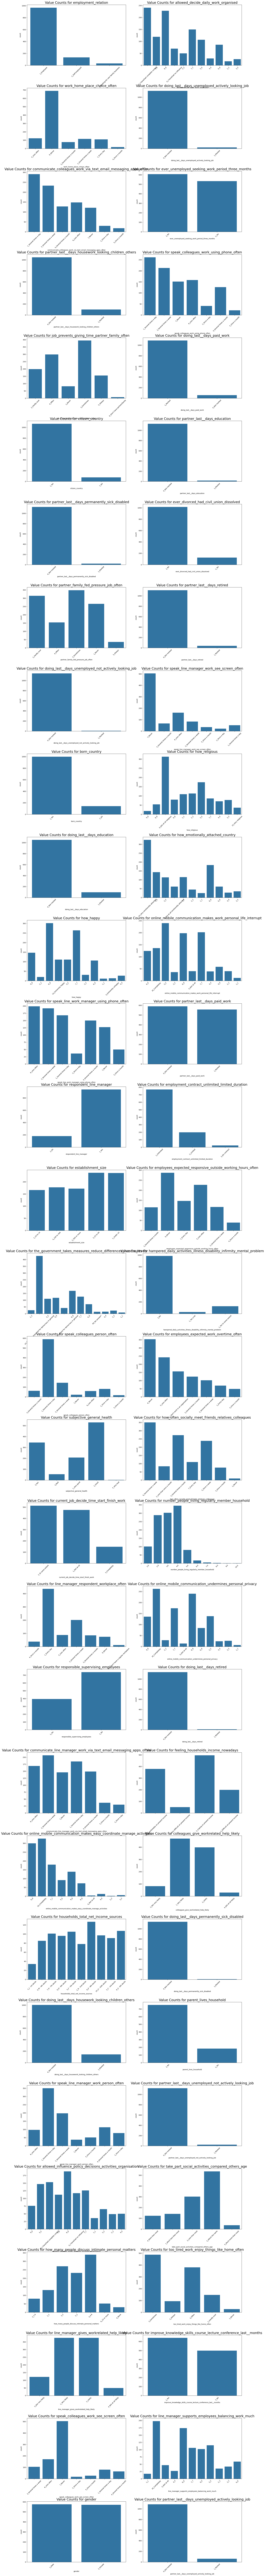

In [ ]:
num_columns = len(data.columns)
subplots_per_row = 2
num_rows = (num_columns + subplots_per_row - 1) // subplots_per_row  # Ceiling division to ensure enough rows

fig, axs = plt.subplots(nrows=num_rows, ncols=subplots_per_row, figsize=(10 * subplots_per_row, 7 * num_rows))
axs = axs.flatten()

jenksnaturalbreaks = ['main_source_household_income',
                      'occupation_isco',
                      'fathers_occupation_respondent_',
                      'what_type_organisation_work_worked',
                      'industry_nace_rev',
                      'highest_level_education_spain',
                      'region',
                      'highest_level_education']

visualization_variables = list(set(categorical_features) | set(nominal_features) - set(jenksnaturalbreaks) - set(['binary_job_satisfaction']))

for idx, column in enumerate(visualization_variables):
    ax = axs[idx]
    sns.countplot(x=column, data=data, ax=ax)
    ax.set_title(f"Value Counts for {column}", fontsize=20)
    ax.tick_params(axis='x', rotation=45)


for ax in axs[idx+1:]:
    ax.set_visible(False)


plt.subplots_adjust(hspace=-5, wspace=-10)
plt.tight_layout()
plt.show()

#### (d). Target Feature

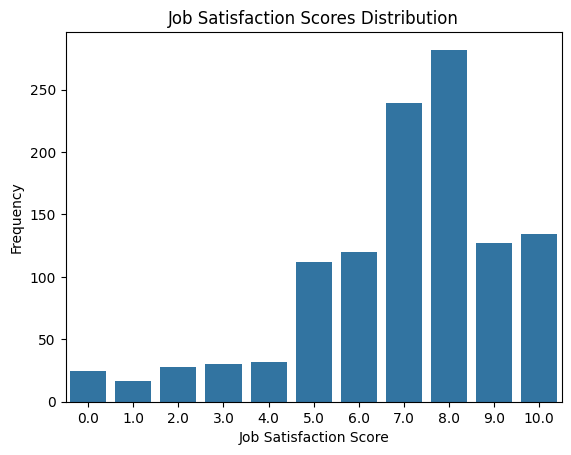

Job Satisfaction Score  Frequency
0                      0.0         25
1                      1.0         17
2                      2.0         28
3                      3.0         30
4                      4.0         32
5                      5.0        112
6                      6.0        120
7                      7.0        239
8                      8.0        282
9                      9.0        127
10                    10.0        134

In [ ]:
target_frequency=data[['how_satisfied_main_job']].value_counts().sort_index().reset_index()

target_frequency.columns = ['Job Satisfaction Score', 'Frequency']

# Plotting
sns.barplot(x='Job Satisfaction Score', y='Frequency', data=target_frequency)
plt.title('Job Satisfaction Scores Distribution')
plt.show()

display(target_frequency)

In [ ]:
print("Median for dependent variable is", data['how_satisfied_main_job'].median())
print("Mean for dependent variable is", data['how_satisfied_main_job'].mean())

Median for dependent variable is 7.0
Mean for dependent variable is 6.965968586387435


**Since both median and mean agree to the cuttoff being 7, we will consider score of 7 to convert the dependent variable from ordinal to binary. Scores higher than 7 are satisfied, lower or equal to 7 are not satisfied.**

In [ ]:
data['binary_job_satisfaction']= np.where(data['how_satisfied_main_job'] > 7, 1, 0)

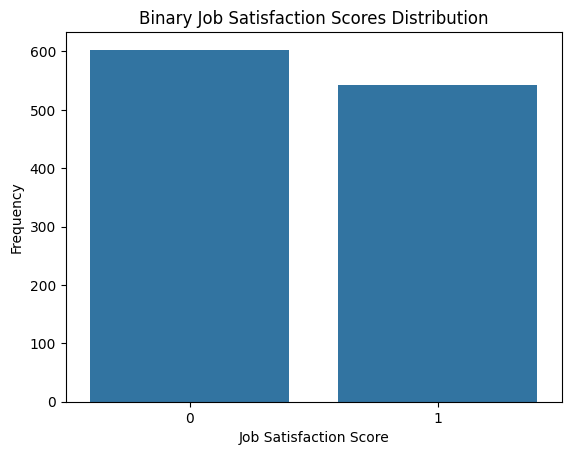

Job Satisfaction Score  Frequency
0                       0        603
1                       1        543

In [ ]:
target_frequency=data[['binary_job_satisfaction']].value_counts().sort_index().reset_index()

target_frequency.columns = ['Job Satisfaction Score', 'Frequency']

# Plotting
sns.barplot(x='Job Satisfaction Score', y='Frequency', data=target_frequency)
plt.title('Binary Job Satisfaction Scores Distribution')
plt.show()

display(target_frequency)

## 1.2 Data Cleaning

Create new covariates for missing or not answered

#### (a). Numeric Features

In [ ]:
display(X_numeric.head())
isNaN=np.isnan(X_numeric)

toto = np.empty((X_numeric.shape))
toto[:] = np.nan                       # Initialization toto
for i in range(0, X_numeric.shape[1]):
    toto[:,i] = (isNaN.iloc[:, i] ==True) * 1

""" toto is matrix of dummy variables equal to 1 if the numeric variable takes a nan, 0 otherwise."""

pval_chi2 = np.empty((X_numeric.shape[1]))
pval_chi2[:] = np.nan             # Initialization pval_chi2

for i in range(0, X_numeric.shape[1]):
    crosstab = pd.crosstab(data['binary_job_satisfaction'], toto[:,i])
    res=stats.chi2_contingency(crosstab)
    pval_chi2[i]=res.pvalue


""" pval_chi2 reports the pvalue of the chi2 test of independence between the dummy
(indicating missing values for the numeric variables) and the dependent variable y.
Small pvalue indicates that the dummy has predictive power to explain y."""

"""We retain the dummies when the Chi-square test of independence displays a p-value lower than 0.05"""

X_num_dumm_miss = pd.DataFrame(toto[:,pval_chi2<0.05])

## Missing values for the variable : "total_hours_normally_worked_per_week_main_job_overtime_included", explains signficiantly the dependent variable. We retain these dummies

""" We fill the nan of the numeric variables that have dummies for missing effect with a 0"""
X_num_clean2=X_numeric.iloc[:, pval_chi2<0.05].fillna(0)


""" For the rest of the numeric variables with missing values which don't bring information to explain the dependent variable,
we use the mean imputation method"""
X_num_clean1=X_numeric.iloc[:, pval_chi2>=0.05].fillna(X_numeric.iloc[:, pval_chi2>=0.05].mean())

""" Set of numeric variables after data cleaning """
X_num_nodummynan=pd.concat([X_num_clean1 ,X_num_clean2], axis=1)

X_num=pd.concat([X_num_clean1 ,X_num_clean2 ], axis=1)

year_birth  age_respondent_calculated  years_fulltime_education_completed  \
0      1955.0                       67.0                                 7.0   
1      1965.0                       57.0                                10.0   
2      1964.0                       58.0                                17.0   
3      1966.0                       56.0                                20.0   
4      1979.0                       43.0                                29.0   

   total_hours_normally_worked_per_week_main_job_overtime_included  
0                                           6.633250                
1                                           6.324555                
2                                           6.480741                
3                                           5.916080                
4                                           7.745967

####(b). Categorical/ Ordinal Features

In [ ]:
X_ordinal_upd = X_ordinal.copy()

for column in X_ordinal_upd.columns:
    new_column = []
    for i in X_ordinal_upd[column]:
        if type(i) == float or type(i) == int:
            new_column.append(i)
        else:
            new_column.append(i.split("_")[0])
    X_ordinal_upd[column] = new_column

X_ordinal_upd = X_ordinal_upd.astype(float)

isNaN=pd.isnull(X_ordinal_upd)

toto = np.empty((X_ordinal_upd.shape)); toto[:] = np.nan                          # Initialization toto
for i in range(0, X_ordinal_upd.shape[1]):
    toto[:,i] = (isNaN.iloc[:, i] ==True) * 1

""" toto is matrix of dummy variables equal to 1 if the numeric variable takes a nan, 0 otherwise."""

pval_chi2 = np.empty((X_ordinal_upd.shape[1]))
pval_chi2[:] = np.nan             # Initialization pval_chi2

for i in range(0, X_ordinal_upd.shape[1]):
    crosstab = pd.crosstab(data['binary_job_satisfaction'],toto[:,i])
    res=stats.chi2_contingency(crosstab)
    pval_chi2[i]=np.round(res.pvalue,2)

print("Dummies retained for variables", X_ordinal_upd.columns[pval_chi2<0.05])

""" pval_chi2 reports the pvalue of the chi2 test of independence between the dummy
(indicating missing values for the numeric variables) and the dependent variable y.
Small pvalue indicates that the dummy has predictive power to explain y."""

# Missing values for the variables : "establishment_size", "online_mobile_communication_makes_easy_coordinate_manage_activities"
##  explains signficiantly the dependent variable. We retain these dummies

""" We fill the nan of the numeric variables that have dummies for missing effect with a 0"""
X_ord_clean2=X_ordinal_upd.iloc[:, pval_chi2<0.05].fillna(0)

""" For the rest of the numeric variables, we use the mean imputation method"""
X_ord_clean1 = X_ordinal_upd.iloc[:, pval_chi2>=0.05].fillna(X_ordinal_upd.iloc[:, pval_chi2>=0.05].median())

X_ord=pd.concat([X_ord_clean1 ,X_ord_clean2 ], axis=1)
X_ord.head()

Dummies retained for variables Index(['establishment_size', 'online_mobile_communication_makes_easy_coordinate_manage_activities'], dtype='object')


employment_relation  allowed_decide_daily_work_organised  \
0                  1.0                                 10.0   
1                  1.0                                  8.0   
2                  2.0                                 10.0   
3                  1.0                                  9.0   
4                  1.0                                 10.0   

   work_home_place_choice_often  \
0                           5.0   
1                           6.0   
2                           3.0   
3                           2.0   
4                           1.0   

   communicate_colleagues_work_via_text_email_messaging_apps_often  \
0                                                1.0                 
1                                                3.0                 
2                                                4.0                 
3                                                3.0                 
4                                                1.0                 

   speak_colleagues_work_using_phone_often  \
0                                      1.0   
1                                      3.0   
2                                      3.0   
3                                      7.0   
4                                      1.0   

   job_prevents_giving_time_partner_family_often  \
0                                            2.0   
1                                            4.0   
2                                            4.0   
3                                            2.0   
4                                            1.0   

   partner_family_fed_pressure_job_often  \
0                                    2.0   
1                                    4.0   
2                                    3.0   
3                                    2.0   
4                                    1.0   

   speak_line_manager_work_see_screen_often  how_religious  \
0                                       7.0            9.0   
1                                       7.0            8.0   
2                                       7.0            0.0   
3                                       7.0            0.0   
4                                       7.0            6.0   

   how_emotionally_attached_country  ...  \
0                              10.0  ...   
1                               9.0  ...   
2                               9.0  ...   
3                               9.0  ...   
4                              10.0  ...   

   speak_line_manager_work_person_often  \
0                                   3.0   
1                                   6.0   
2                                   3.0   
3                                   1.0   
4                                   3.0   

   allowed_influence_policy_decisions_activities_organisation  \
0                                                9.0            
1                                                5.0            
2                                               10.0            
3                                                6.0            
4                                                9.0            

   take_part_social_activities_compared_others_age  \
0                                              4.0   
1                                              1.0   
2                                              2.0   
3                                              1.0   
4                                              4.0   

   how_many_people_discuss_intimate_personal_matters  \
0                                                5.0   
1                                                1.0   
2                                                1.0   
3                                                3.0   
4                                                2.0   

   too_tired_work_enjoy_things_like_home_often  \
0                                          3.0   
1                                          5.0   
2                                    

#### (c). Nominal Variables

In [ ]:
nominal_columns = list(set(list(X_nominal.columns)) - set(jenksnaturalbreaks))

X_nominal_upd = pd.get_dummies(X_nominal[nominal_columns], dummy_na=True)

isNaN_mask = (X_nominal_upd.columns.str.contains("nan")) & (X_nominal_upd==1)
isNaN= X_nominal_upd[isNaN_mask]

toto = np.empty((X_nominal_upd.shape)); toto[:] = np.nan                          # Initialization toto

for i in range(0, X_nominal_upd.shape[1]):
    toto[:,i] = (isNaN.iloc[:, i] ==True) * 1

""" toto is matrix of dummy variables equal to 1 if the numeric variable takes a nan, 0 otherwise."""

pval_chi2 = np.empty((X_nominal_upd.shape[1]))
pval_chi2[:] = np.nan             # Initialization pval_chi2

for i in range(0, X_nominal_upd.shape[1]):
    crosstab = pd.crosstab(data['binary_job_satisfaction'],toto[:,i])
    res=stats.chi2_contingency(crosstab)
    pval_chi2[i]=np.round(res.pvalue,2)

print("Dummies retained for variables", X_nominal_upd.columns[pval_chi2<0.05])


""" pval_chi2 reports the pvalue of the chi2 test of independence between the dummy
(indicating missing values for the numeric variables) and the dependent variable y.
Small pvalue indicates that the dummy has predictive power to explain y."""

""" Columns to drop - pval_chi2 >= 0.05 """

""" We fill the nan of the numeric variables that have dummies for missing effect with a 0"""
insignificant_nan_columns = [i for i in X_nominal_upd.columns[pval_chi2>=0.05] if 'nan' in i]

X_nom1 = X_nominal_upd.drop(columns=insignificant_nan_columns)
X_nom1.head()

Dummies retained for variables Index(['employment_contract_unlimited_limited_duration_nan'], dtype='object')


doing_last__days_unemployed_actively_looking_job_0_Not marked  \
0                                                  1               
1                                                  1               
2                                                  1               
3                                                  1               
4                                                  1               

   doing_last__days_unemployed_actively_looking_job_1_Marked  \
0                                                  0           
1                                                  0           
2                                                  0           
3                                                  0           
4                                                  0           

   ever_unemployed_seeking_work_period_three_months_1_Yes  \
0                                                  0        
1                                                  1        
2                                                  0        
3                                                  1        
4                                                  0        

   ever_unemployed_seeking_work_period_three_months_2_No  \
0                                                  1       
1                                                  0       
2                                                  1       
3                                                  0       
4                                                  1       

   partner_last__days_housework_looking_children_others_0_Not marked  \
0                                                  1                   
1                                                  1                   
2                                                  1                   
3                                                  1                   
4                                                  1                   

   partner_last__days_housework_looking_children_others_1_Marked  \
0                                                  0               
1                                                  0               
2                                                  0               
3                                                  0               
4                                                  0               

   doing_last__days_paid_work_0_Not marked  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   doing_last__days_paid_work_1_Marked  citizen_country_1_Yes  \
0                                    1                      1   
1                                    1                      1   
2                                    1                      1   
3                                    1                      1   
4                                    1                      1   

   citizen_country_2_No  ...  parent_lives_household_1_Yes  \
0                     0  ...                             0   
1                     0  ...                             0   
2                     0  ...                             0   
3                     0  ...                             1   
4                     0  ...                             0   

   parent_lives_household_2_No  \
0                            0   
1                            0   
2                            1   
3                            0   
4                            1   

   partner_last__days_unemployed_not_actively_looking_job_0_Not marked  \
0                                                  1                     
1                                                  1                     
2                                                  0                     
3                                                  1                     
4                      

## 1.3 Data Categorization

We merge nominal covariates into smaller number of classes using Odd analysis. We group classes that have similar odd.
Then use k-means algorithm on the odd variable

In [ ]:
jenksnaturalbreaks = ['main_source_household_income',
                      'occupation_isco',
                      'fathers_occupation_respondent_',
                      'what_type_organisation_work_worked',
                      'industry_nace_rev',
                      'highest_level_education_spain',
                      'region',
                      'highest_level_education']


jenksnaturalbreaks_mapping = {}

X_nominal_cluster_data = data[jenksnaturalbreaks]

for nominal_column_name in jenksnaturalbreaks:

    crosstab = pd.crosstab(data['binary_job_satisfaction'], data[nominal_column_name])
    res=stats.chi2_contingency(crosstab)

    """pvalue<0.05 indicates a link between the dependent variable and the nominal variable. We retain the variable nominal variable """

    nominal_column = data[nominal_column_name].fillna("XX")
    crosstab = pd.crosstab(data["binary_job_satisfaction"], nominal_column)
    odds = crosstab.iloc[0]/crosstab.iloc[1]                # Odds for each class levels of the nominal variable
    odds = odds.replace([np.inf, -np.inf], np.nan, inplace=False)
    odds = odds.dropna(inplace=False)

    jnb = JenksNaturalBreaks(3)                           # Asking for 3 clusters/groups of categories that have similar odds
    jnb.fit(odds)                                         # Create the clusters according to values in 'odds'

    classlevels = odds.index
    classlevels=classlevels.to_frame()                    # Create a variable with the list of class levels of variable
    classlevels=classlevels.reset_index(drop=True)        # Remove raw labels from classlevels for merging
    cluster=pd.DataFrame(jnb.labels_,columns=['Cluster']) # Create the list of subgroups (to be merged with class levels)
    nominal_columnref=pd.concat([cluster, classlevels], axis=1)      # Reference of the class levels and the new considered categories
                                                        # Group 0: Mgr, other, Sales, Self, Group 1: Office, ProfExe, Group 2: XX (missing values)
    lst = list(range(0,len(nominal_column)))
    index=pd.DataFrame(lst,columns=['index'])
    nominal_columnindexed=pd.concat([nominal_column, index], axis=1)            # Variable  with the raw labels as a variable

    nominal_columnsubcat = pd.merge(nominal_columnindexed,nominal_columnref)               # Merge of the datasets such that variable displays the cluster/group for each observations
    nominal_columnsubcat.sort_values(by=['index'], inplace=True)    # Sort of variable to get back the original ordering of the data.

    # nominal_columnsubcat[nominal_column_name].replace('XX', np.nan,inplace=True)

    nominal_columnsubcat = nominal_columnsubcat.drop_duplicates()

    cluster_mapping = {nominal_columnsubcat[nominal_column_name][i] : str(nominal_columnsubcat['Cluster'][i]) for i in range(len(nominal_columnsubcat)) }

    """ 'nominal_columnsubcat' includes the variable 'Cluster' which is the output of the data categorization performed on nominal_variables """

    X_nominal_cluster_data[nominal_column_name] = [cluster_mapping[i] if i in cluster_mapping.keys() else '0' for i in data[nominal_column_name] ]

In [ ]:
X_nominal_cluster_data.head()

main_source_household_income occupation_isco fathers_occupation_respondent_  \
0                            2               0                              0   
1                            2               0                              0   
2                            1               0                              0   
3                            2               1                              2   
4                            2               0                              0   

  what_type_organisation_work_worked industry_nace_rev  \
0                                  2                 0   
1                                  2                 0   
2                                  1                 1   
3                                  0                 0   
4                                  0                 0   

  highest_level_education_spain region highest_level_education  
0                             0      1                       0  
1                             0      0                       0  
2                             0      0                       0  
3                             0      0                       1  
4                             0      1                       1

In [ ]:
## Created a mapping of the clusters (from ChatGPT)

cluster_mapping = {
    "main_source_household_income": {
        "0": "No Income",
        "1": "Self-Employment and Unemployment Benefits",
        "2": "Wages, Salaries, Pensions, and Farming Income"
    },
    "occupation_isco": {
        "0": "Construction and Related Trades",
        "1": "Administrative, Education, and Health Professionals",
        "2": "Drivers, Software Developers, and Miscellaneous"
    },
    "fathers_occupation_respondent_": {
        "0": "Clerical and Service Occupations",
        "1": "Skilled and Semi-Skilled Workers",
        "2": "Unskilled Workers"
    },
    "what_type_organisation_work_worked": {
        "0": "Government and Public Sector",
        "1": "Private Firms, Self-Employed, and Other Sectors",
        "2": "Miscellaneous"
    },
    "industry_nace_rev": {
        "0": "Manufacturing and Construction",
        "1": "Services, Health, and Education",
        "2": "Transportation and Miscellaneous"
    },
    "highest_level_education_spain": {
        "0": "Higher Education and Doctorate",
        "1": "Secondary Education and Vocational Training",
        "2": "Less than Secondary Education"
    },
    "region": {
        "0": "Northern and Central Regions",
        "1": "Southern Regions",
        "2": "Basque Country, Navarra, and Extremadura"
    },
    "highest_level_education": {
        "0": "Higher Education and Doctoral Degree",
        "1": "Secondary and Vocational Education",
        "2": "Incomplete Primary Education"
    }
}

X_nom2 = X_nominal_cluster_data.copy()

for column in X_nom2.columns:
    X_nom2[column] = [cluster_mapping[column][i] for i in X_nom2[column]]

X_nom2 = pd.get_dummies(X_nom2)
X_nom2.head()

main_source_household_income_No Income  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   

   main_source_household_income_Self-Employment and Unemployment Benefits  \
0                                                  0                        
1                                                  0                        
2                                                  1                        
3                                                  0                        
4                                                  0                        

   main_source_household_income_Wages, Salaries, Pensions, and Farming Income  \
0                                                  1                            
1                                                  1                            
2                                                  0                            
3                                                  1                            
4                                                  1                            

   occupation_isco_Administrative, Education, and Health Professionals  \
0                                                  0                     
1                                                  0                     
2                                                  0                     
3                                                  1                     
4                                                  0                     

   occupation_isco_Construction and Related Trades  \
0                                                1   
1                                                1   
2                                                1   
3                                                0   
4                                                1   

   occupation_isco_Drivers, Software Developers, and Miscellaneous  \
0                                                  0                 
1                                                  0                 
2                                                  0                 
3                                                  0                 
4                                                  0                 

   fathers_occupation_respondent__Clerical and Service Occupations  \
0                                                  1                 
1                                                  1                 
2                                                  1                 
3                                                  0                 
4                                                  1                 

   fathers_occupation_respondent__Skilled and Semi-Skilled Workers  \
0                                                  0                 
1                                                  0                 
2                                                  0                 
3                                                  0                 
4                                                  0                 

   fathers_occupation_respondent__Unskilled Workers  \
0                                                 0   
1                                                 0   
2                                                 0   
3                                                 1   
4                                                 0   

   what_type_organisation_work_worked_Government and Public Sector  ...  \
0                                                  0                ...   
1                                                  0                ...   
2                                                  0                ...   
3                                                  1                ...   
4                                          

In [ ]:
# Checking if all variables are considered

print(len(data.columns) - 2 ),

print(len(X_num.columns), len(numerical_features), list(X_num.columns), '\n   ', numerical_features)
print(len(list(X_ord.columns)), len(categorical_features), sorted(list(X_ord.columns)), '\n     ', sorted(categorical_features))
print(len(list(X_nom1.columns) + list(X_nom2.columns)),
      len(nominal_features), sorted(list(X_nom1.columns) + list(X_nom2.columns)), '\n     ', sorted(nominal_features))

print(len(data.columns) - 2, X_num.shape[1] + X_ord.shape[1] + X_nom1.shape[1] + X_nom2.shape[1])

74
4 4 ['year_birth', 'age_respondent_calculated', 'years_fulltime_education_completed', 'total_hours_normally_worked_per_week_main_job_overtime_included'] 
    ['year_birth', 'age_respondent_calculated', 'years_fulltime_education_completed', 'total_hours_normally_worked_per_week_main_job_overtime_included']
38 38 ['allowed_decide_daily_work_organised', 'allowed_influence_policy_decisions_activities_organisation', 'colleagues_give_workrelated_help_likely', 'communicate_colleagues_work_via_text_email_messaging_apps_often', 'communicate_line_manager_work_via_text_email_messaging_apps_often', 'current_job_decide_time_start_finish_work', 'employees_expected_responsive_outside_working_hours_often', 'employees_expected_work_overtime_often', 'employment_relation', 'establishment_size', 'feeling_households_income_nowadays', 'hampered_daily_activities_illness_disability_infirmity_mental_problem', 'households_total_net_income_sources', 'how_emotionally_attached_country', 'how_happy', 'how_many_p

In [ ]:
y_true = data[['binary_job_satisfaction']]

In [ ]:
"""
FINAL DATASETS TO BE USED

X variables

1. X_num
2. X_ord
3. X_nom
4. X_nominal_cluster_data

Y variable - y_true

"""

# function
def dfs_tabs(df_list, sheet_list, file_name):
    writer = pd.ExcelWriter(file_name,engine='xlsxwriter')
    for dataframe, sheet in zip(df_list, sheet_list):
        dataframe.to_excel(writer, sheet_name=sheet, startrow=0 , startcol=0, index=False)
    writer.save()

# list of dataframes and sheet names
dfs = [X_nom1, X_nom2, X_num, X_ord, y_true]
sheets = ['X_nom1','X_nom2','X_num', 'X_ord', 'y_true']

# run function
dfs_tabs(dfs, sheets, 'Pre-processed dataset - version 5.xlsx')

# (2). Create a Richer Set of Covariates

In [ ]:
preprocessed_data_file = os.path.join(data_folder,  'Pre-processed dataset - version 5.xlsx')

X_nom1 = pd.read_excel(preprocessed_data_file, sheet_name='X_nom1')
X_nom2 = pd.read_excel(preprocessed_data_file, sheet_name='X_nom2')
X_num = pd.read_excel(preprocessed_data_file, sheet_name='X_num')
X_ord = pd.read_excel(preprocessed_data_file, sheet_name='X_ord')

y_true_df = pd.read_excel(preprocessed_data_file, sheet_name='y_true')
y_true = y_true_df.to_numpy().reshape(-1)

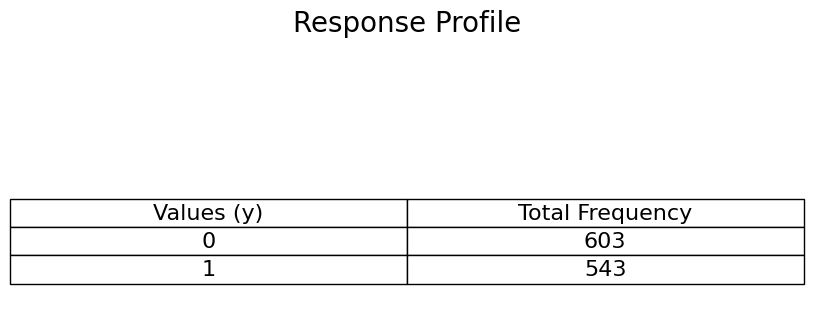

In [ ]:
responseprofile(y_true_df)

In [ ]:
variable_category_mapping = json.load(open(os.path.join(data_folder, 'Variables - Category mapping.json'), 'r'))
print(variable_category_mapping.keys())

dict_keys(['how_happy', 'how_often_socially_meet_friends_relatives_colleagues', 'how_many_people_discuss_intimate_personal_matters', 'take_part_social_activities_compared_others_age', 'subjective_general_health', 'hampered_daily_activities_illness_disability_infirmity_mental_problem', 'how_emotionally_attached_country', 'how_religious', 'citizen_country', 'born_country', 'the_government_takes_measures_reduce_differences_income_levels', 'number_people_living_regularly_member_household', 'gender', 'year_birth', 'age_respondent_calculated', 'ever_divorced_had_civil_union_dissolved', 'highest_level_education', 'highest_level_education_spain', 'years_fulltime_education_completed', 'doing_last__days_paid_work', 'doing_last__days_education', 'doing_last__days_unemployed_actively_looking_job', 'doing_last__days_unemployed_not_actively_looking_job', 'doing_last__days_permanently_sick_disabled', 'doing_last__days_retired', 'doing_last__days_housework_looking_children_others', 'employment_relatio

## 2.1 **Model 1 : Only Categorical Variables/Binned Model**

### 2.1.1 Creating a Richer set of covariates

#### (a). Binning Numerical Variables

In [ ]:
X_num[['year_birth']].quantile([0.25,0.5,0.75])

year_birth
0.25      1968.0
0.50      1976.0
0.75      1985.0

In [ ]:
bin_year_birth=np.digitize(X_num[['year_birth']],[1968,1976,1985])
bin_year_birth=pd.DataFrame(data=bin_year_birth, columns=['binned_year_birth'])
dum_year_birth=pd.get_dummies(bin_year_birth['binned_year_birth'])
dum_year_birth=dum_year_birth.rename(columns={0: 'year_birth<1968', 1:'1968<=year_birth<1976', 2:'1976<=year_birth<1985', 3:'year_birth>=1985'})
dum_year_birth.head()

year_birth<1968  1968<=year_birth<1976  1976<=year_birth<1985  \
0                1                      0                      0   
1                1                      0                      0   
2                1                      0                      0   
3                1                      0                      0   
4                0                      0                      1   

   year_birth>=1985  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

In [ ]:
X_num[['age_respondent_calculated']].quantile([0.25,0.5,0.75])

age_respondent_calculated
0.25                       37.0
0.50                       46.0
0.75                       54.0

In [ ]:
bin_age_respondent_calculated=np.digitize(X_num[['age_respondent_calculated']],[37,46,54])
bin_age_respondent_calculated=pd.DataFrame(data=bin_age_respondent_calculated, columns=['binned_age_respondent_calculated'])
dum_age_respondent_calculated=pd.get_dummies(bin_age_respondent_calculated['binned_age_respondent_calculated'])
dum_age_respondent_calculated=dum_age_respondent_calculated.rename(columns={0: 'age_respondent_calculated<37', 1:'37<=age_respondent_calculated<46', 2:'46<=age_respondent_calculated<54', 3:'age_respondent_calculated>=54'})
dum_age_respondent_calculated.head()

age_respondent_calculated<37  37<=age_respondent_calculated<46  \
0                             0                                 0   
1                             0                                 0   
2                             0                                 0   
3                             0                                 0   
4                             0                                 1   

   46<=age_respondent_calculated<54  age_respondent_calculated>=54  
0                                 0                              1  
1                                 0                              1  
2                                 0                              1  
3                                 0                              1  
4                                 0                              0

In [ ]:
X_num[['years_fulltime_education_completed']].quantile([0.25,0.5,0.75])

years_fulltime_education_completed
0.25                                11.0
0.50                                15.0
0.75                                19.0

In [ ]:
bin_years_fulltime_education_completed = np.digitize(X_num[['years_fulltime_education_completed']], [11, 15, 19])
bin_years_fulltime_education_completed = pd.DataFrame(data=bin_years_fulltime_education_completed, columns=['binned_years_fulltime_education_completed'])
dum_years_fulltime_education_completed = pd.get_dummies(bin_years_fulltime_education_completed['binned_years_fulltime_education_completed'])
dum_years_fulltime_education_completed = dum_years_fulltime_education_completed.rename(columns={
    0: 'years_fulltime_education_completed<11',
    1: '11<=years_fulltime_education_completed<15',
    2: '15<=years_fulltime_education_completed<19',
    3: 'years_fulltime_education_completed>=19'
})
dum_years_fulltime_education_completed.head()

years_fulltime_education_completed<11  \
0                                      1   
1                                      1   
2                                      0   
3                                      0   
4                                      0   

   11<=years_fulltime_education_completed<15  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   15<=years_fulltime_education_completed<19  \
0                                          0   
1                                          0   
2                                          1   
3                                          0   
4                                          0   

   years_fulltime_education_completed>=19  
0                                       0  
1                                       0  
2                                       0  
3                                       1  
4                                       1

In [ ]:
X_num[['total_hours_normally_worked_per_week_main_job_overtime_included']].quantile([0.25,0.5,0.75])

total_hours_normally_worked_per_week_main_job_overtime_included
0.25                                           5.477226              
0.50                                           6.324555              
0.75                                           6.557439

In [ ]:
bin_total_hours_normally_worked_per_week_main_job_overtime_included = np.digitize(X_num[['total_hours_normally_worked_per_week_main_job_overtime_included']], [5.47, 6.32, 6.55])
bin_total_hours_normally_worked_per_week_main_job_overtime_included = pd.DataFrame(data=bin_total_hours_normally_worked_per_week_main_job_overtime_included, columns=['binned_total_hours_normally_worked_per_week_main_job_overtime_included'])
dum_total_hours_normally_worked_per_week_main_job_overtime_included = pd.get_dummies(bin_total_hours_normally_worked_per_week_main_job_overtime_included['binned_total_hours_normally_worked_per_week_main_job_overtime_included'])
dum_total_hours_normally_worked_per_week_main_job_overtime_included = dum_total_hours_normally_worked_per_week_main_job_overtime_included.rename(columns={
    0: 'total_hours_normally_worked_per_week_main_job_overtime_included<5.47',
    1: '5.477226<=total_hours_normally_worked_per_week_main_job_overtime_included<6.32',
    2: '6.324555<=total_hours_normally_worked_per_week_main_job_overtime_included<6.55',
    3: 'total_hours_normally_worked_per_week_main_job_overtime_included>=6.55'
})

dum_total_hours_normally_worked_per_week_main_job_overtime_included.head()

total_hours_normally_worked_per_week_main_job_overtime_included<5.47  \
0                                                  0                      
1                                                  0                      
2                                                  0                      
3                                                  0                      
4                                                  0                      

   5.477226<=total_hours_normally_worked_per_week_main_job_overtime_included<6.32  \
0                                                  0                                
1                                                  0                                
2                                                  0                                
3                                                  1                                
4                                                  0                                

   6.324555<=total_hours_normally_worked_per_week_main_job_overtime_included<6.55  \
0                                                  0                                
1                                                  1                                
2                                                  1                                
3                                                  0                                
4                                                  0                                

   total_hours_normally_worked_per_week_main_job_overtime_included>=6.55  
0                                                  1                      
1                                                  0                      
2                                                  0                      
3                                                  0                      
4                                                  1

In [ ]:
dum_bin_X_num = pd.concat([dum_year_birth, dum_age_respondent_calculated,dum_years_fulltime_education_completed,dum_total_hours_normally_worked_per_week_main_job_overtime_included],  axis=1)
dum_bin_X_num.head()

year_birth<1968  1968<=year_birth<1976  1976<=year_birth<1985  \
0                1                      0                      0   
1                1                      0                      0   
2                1                      0                      0   
3                1                      0                      0   
4                0                      0                      1   

   year_birth>=1985  age_respondent_calculated<37  \
0                 0                             0   
1                 0                             0   
2                 0                             0   
3                 0                             0   
4                 0                             0   

   37<=age_respondent_calculated<46  46<=age_respondent_calculated<54  \
0                                 0                                 0   
1                                 0                                 0   
2                                 0                                 0   
3                                 0                                 0   
4                                 1                                 0   

   age_respondent_calculated>=54  years_fulltime_education_completed<11  \
0                              1                                      1   
1                              1                                      1   
2                              1                                      0   
3                              1                                      0   
4                              0                                      0   

   11<=years_fulltime_education_completed<15  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   15<=years_fulltime_education_completed<19  \
0                                          0   
1                                          0   
2                                          1   
3                                          0   
4                                          0   

   years_fulltime_education_completed>=19  \
0                                       0   
1                                       0   
2                                       0   
3                                       1   
4                                       1   

   total_hours_normally_worked_per_week_main_job_overtime_included<5.47  \
0                                                  0                      
1                                                  0                      
2                                                  0                      
3                                                  0                      
4                                                  0                      

   5.477226<=total_hours_normally_worked_per_week_main_job_overtime_included<6.32  \
0                                                  0                                
1                                                  0                                
2                                                  0                                
3                                                  1                                
4                                                  0                                

   6.324555<=total_hours_normally_worked_per_week_main_job_overtime_included<6.55  \
0                                                  0                                
1                                                  1                                
2                                                  1                                
3                                                  0                                
4                                                  0                                

   total_hours_normally_worked_per_week_main_job_overtime_inclu

#### (b). Binning Ordinal Variables

In [ ]:
ordinal_columns = [
    'allowed_decide_daily_work_organised', 'allowed_influence_policy_decisions_activities_organisation',
    'colleagues_give_workrelated_help_likely', 'communicate_colleagues_work_via_text_email_messaging_apps_often',
    'communicate_line_manager_work_via_text_email_messaging_apps_often', 'current_job_decide_time_start_finish_work',
    'employees_expected_responsive_outside_working_hours_often', 'employees_expected_work_overtime_often', 'employment_relation',
    'feeling_households_income_nowadays', 'hampered_daily_activities_illness_disability_infirmity_mental_problem',
    'households_total_net_income_sources', 'how_emotionally_attached_country', 'how_happy',
    'how_many_people_discuss_intimate_personal_matters', 'how_often_socially_meet_friends_relatives_colleagues', 'how_religious',
    'job_prevents_giving_time_partner_family_often', 'line_manager_gives_workrelated_help_likely',
    'line_manager_respondent_workplace_often', 'line_manager_supports_employees_balancing_work_much',
    'number_people_living_regularly_member_household', 'online_mobile_communication_makes_work_personal_life_interrupt',
    'online_mobile_communication_undermines_personal_privacy', 'partner_family_fed_pressure_job_often',
    'speak_colleagues_person_often', 'speak_colleagues_work_see_screen_often', 'speak_colleagues_work_using_phone_often',
    'speak_line_manager_work_person_often', 'speak_line_manager_work_see_screen_often', 'speak_line_work_manager_using_phone_often',
    'subjective_general_health', 'take_part_social_activities_compared_others_age',
    'the_government_takes_measures_reduce_differences_income_levels', 'too_tired_work_enjoy_things_like_home_often',
    'work_home_place_choice_often', 'online_mobile_communication_makes_easy_coordinate_manage_activities'
]


dum_bin_X_ord = pd.DataFrame()
reference_classes = {}  # Initialize dictionary to store reference classes

for column in ordinal_columns:
    # Bin the column into 5 categories
    binned_col = pd.cut(X_ord[column], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'], retbins=False)

    # Convert binned columns into dummy variables
    dummies = pd.get_dummies(binned_col, prefix=column)

    # Find the most frequent category (reference class) for the column
    reference_class = dummies.sum().idxmax()

    # Store the reference class in the dictionary
    reference_classes[column] = reference_class

    # Drop the reference class column from dummies to avoid multicollinearity
    dummies = dummies.drop(columns=reference_class)

    # Concatenate the modified dummy variables to the existing DataFrame
    dum_bin_X_ord = pd.concat([dum_bin_X_ord, dummies], axis=1)

dum_bin_X_ord.head()

allowed_decide_daily_work_organised_Very Low  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   allowed_decide_daily_work_organised_Low  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   allowed_decide_daily_work_organised_Medium  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   allowed_decide_daily_work_organised_Very High  \
0                                              1   
1                                              0   
2                                              1   
3                                              1   
4                                              1   

   allowed_influence_policy_decisions_activities_organisation_Very Low  \
0                                                  0                     
1                                                  0                     
2                                                  0                     
3                                                  0                     
4                                                  0                     

   allowed_influence_policy_decisions_activities_organisation_Low  \
0                                                  0                
1                                                  0                
2                                                  0                
3                                                  0                
4                                                  0                

   allowed_influence_policy_decisions_activities_organisation_Medium  \
0                                                  0                   
1                                                  1                   
2                                                  0                   
3                                                  1                   
4                                                  0                   

   allowed_influence_policy_decisions_activities_organisation_Very High  \
0                                                  1                      
1                                                  0                      
2                                                  1                      
3                                                  0                      
4                                                  1                      

   colleagues_give_workrelated_help_likely_Very Low  \
0                                                 0   
1                                                 0   
2                                                 1   
3                                                 1   
4                                                 0   

   colleagues_give_workrelated_help_likely_Medium  ...  \
0                                               0  ...   
1                                               0  ...   
2                                               0  ...   
3                                               0  ...   
4                                               0  ...   

   too_tired_work_enjoy_things_like_home_often_High  \
0                                                 0   
1                                                 0   
2                                                 1   
3                                                 0   
4                                                 0   

   too_tired_work_enjoy_things_like_home_often_Very High

In [ ]:
reference_classes

{'allowed_decide_daily_work_organised': 'allowed_decide_daily_work_organised_High',
 'allowed_influence_policy_decisions_activities_organisation': 'allowed_influence_policy_decisions_activities_organisation_High',
 'colleagues_give_workrelated_help_likely': 'colleagues_give_workrelated_help_likely_Low',
 'communicate_colleagues_work_via_text_email_messaging_apps_often': 'communicate_colleagues_work_via_text_email_messaging_apps_often_Low',
 'communicate_line_manager_work_via_text_email_messaging_apps_often': 'communicate_line_manager_work_via_text_email_messaging_apps_often_Medium',
 'current_job_decide_time_start_finish_work': 'current_job_decide_time_start_finish_work_Medium',
 'employees_expected_responsive_outside_working_hours_often': 'employees_expected_responsive_outside_working_hours_often_High',
 'employees_expected_work_overtime_often': 'employees_expected_work_overtime_often_Very Low',
 'employment_relation': 'employment_relation_Very Low',
 'feeling_households_income_nowada

In [ ]:
reference_classes_upd = {}
for key, value in reference_classes.items():
    reference_classes_upd[key] = value.strip().split('_')[-1]

reference_classes_upd

{'allowed_decide_daily_work_organised': 'High',
 'allowed_influence_policy_decisions_activities_organisation': 'High',
 'colleagues_give_workrelated_help_likely': 'Low',
 'communicate_colleagues_work_via_text_email_messaging_apps_often': 'Low',
 'communicate_line_manager_work_via_text_email_messaging_apps_often': 'Medium',
 'current_job_decide_time_start_finish_work': 'Medium',
 'employees_expected_responsive_outside_working_hours_often': 'High',
 'employees_expected_work_overtime_often': 'Very Low',
 'employment_relation': 'Very Low',
 'feeling_households_income_nowadays': 'Low',
 'hampered_daily_activities_illness_disability_infirmity_mental_problem': 'Very High',
 'households_total_net_income_sources': 'Medium',
 'how_emotionally_attached_country': 'Very High',
 'how_happy': 'High',
 'how_many_people_discuss_intimate_personal_matters': 'High',
 'how_often_socially_meet_friends_relatives_colleagues': 'Very High',
 'how_religious': 'Very Low',
 'job_prevents_giving_time_partner_family

We already have dummies for nominal variables from the previous variable selection step, so we use those dataframes. We create a dataframe with all the binned dummies from numerical, ordinal and nominal variables.

In [ ]:
full_dum_binned = pd.concat([dum_bin_X_num,
                            dum_bin_X_ord, X_nom1, X_nom2], axis = 1)
display(full_dum_binned.head())
display(full_dum_binned.shape)

year_birth<1968  1968<=year_birth<1976  1976<=year_birth<1985  \
0                1                      0                      0   
1                1                      0                      0   
2                1                      0                      0   
3                1                      0                      0   
4                0                      0                      1   

   year_birth>=1985  age_respondent_calculated<37  \
0                 0                             0   
1                 0                             0   
2                 0                             0   
3                 0                             0   
4                 0                             0   

   37<=age_respondent_calculated<46  46<=age_respondent_calculated<54  \
0                                 0                                 0   
1                                 0                                 0   
2                                 0                                 0   
3                                 0                                 0   
4                                 1                                 0   

   age_respondent_calculated>=54  years_fulltime_education_completed<11  \
0                              1                                      1   
1                              1                                      1   
2                              1                                      0   
3                              1                                      0   
4                              0                                      0   

   11<=years_fulltime_education_completed<15  ...  \
0                                          0  ...   
1                                          0  ...   
2                                          0  ...   
3                                          0  ...   
4                                          0  ...   

   industry_nace_rev_Transportation and Miscellaneous  \
0                                                  0    
1                                                  0    
2                                                  0    
3                                                  0    
4                                                  0    

   highest_level_education_spain_Higher Education and Doctorate  \
0                                                  1              
1                                                  1              
2                                                  1              
3                                                  1              
4                                                  1              

   highest_level_education_spain_Less than Secondary Education  \
0                                                  0             
1                                                  0             
2                                                  0             
3                                                  0             
4                                                  0             

   highest_level_education_spain_Secondary Education and Vocational Training  \
0                                                  0                           
1                                                  0                           
2                                                  0                           
3                                                  0                           
4                                                  0                           

   region_Basque Country, Navarra, and Extremadura  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   region_Northern and Central Regions  region_Southern Regions  \
0                                    0            

(1146, 242)

In [ ]:
# Building our y variable

y_true_df = pd.read_excel(preprocessed_data_file, sheet_name='y_true')
ynp = y_true_df['binary_job_satisfaction'].to_numpy()

### 2.1.2. Variable Selection

We use the Chi-squared test of independence to select variables for a model. This test is applied to each variable in the dataset to check if there's a statistically significant association between each independent variable and the dependent variable.

In [ ]:
## We test if the correlation between the dependent variable y and each explanatory variable x1, x2, ... is statistically significant at a given significance level α
#x/y Parametric tests Non parametric tests

# Numeric / Nominal One-way ANOVA test Kruskal-Wallis test
# Ordinal / Nominal One-way ANOVA test Kruskal-Wallis test
# Nominal / Nominal Chi-Square test of independence Fisher’s exact test

# K/N < 15%

In [ ]:
from scipy.stats import chi2_contingency

chi2_res = np.empty(full_dum_binned.shape[1])

for i in range(full_dum_binned.shape[1]):
    contingency_table = pd.crosstab(ynp, full_dum_binned.iloc[:, i])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi2_res[i] = p

chi2_ayo = np.ravel(chi2_res < 0.05)
reduced_dum_binned = full_dum_binned.iloc[:, chi2_ayo]
reduced_dum_binned

year_birth>=1985  age_respondent_calculated<37  \
0                    0                             0   
1                    0                             0   
2                    0                             0   
3                    0                             0   
4                    0                             0   
...                ...                           ...   
1141                 1                             1   
1142                 0                             0   
1143                 0                             0   
1144                 0                             0   
1145                 1                             1   

      allowed_decide_daily_work_organised_Very Low  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   
...                                            ...   
1141                                             0   
1142                                             0   
1143                                             1   
1144                                             0   
1145                                             1   

      allowed_decide_daily_work_organised_Low  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   
...                                       ...   
1141                                        0   
1142                                        0   
1143                                        0   
1144                                        0   
1145                                        0   

      allowed_decide_daily_work_organised_Medium  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   
...                                          ...   
1141                                           1   
1142                                           0   
1143                                           0   
1144                                           0   
1145                                           0   

      allowed_decide_daily_work_organised_Very High  \
0                                                 1   
1                                                 0   
2                                                 1   
3                                                 1   
4                                                 1   
...                                             ...   
1141                                              0   
1142                                              0   
1143                                              0   
1144                                              1   
1145                                              0   

      allowed_influence_policy_decisions_activities_organisation_Very Low  \
0                                                     0                     
1                                                     0                     
2                                                     0                     
3                                                     0                     
4                                                     0                     
...                                                 ...                     
1141                                                  0                     
1142                                                  0                     
1143                                                  1                     
1144                                   

### 2.1.3. Checking for Multicollinearity

At this step, we use the Spearman's rank correlation coefficient for all pairs of variables in the previous reduced dataset, identifying pairs with a correlation above a threshold (0.7), and removing one variable from each highly correlated pair to further reduce the dataset's dimensionality.

In [ ]:
from scipy.stats import spearmanr

var = reduced_dum_binned.shape[1]  # Number of variables/features in the reduced dataset
nb = int((var**2 - var) / 2)  # Number of variable pairs
pairs_of_var = np.empty((nb, 3))

iter = 0
for i in range(0, var-1):
    for j in range(i+1, var):
        res = spearmanr(reduced_dum_binned.iloc[:, i], reduced_dum_binned.iloc[:, j])
        pairs_of_var[iter, [0, 1]] = [i, j]
        pairs_of_var[iter, 2] = res.correlation  # Store the Spearman correlation coefficient
        iter += 1

kappa = 0.7

ayo = abs(pairs_of_var[:, 2]) > kappa
ttt = pairs_of_var[ayo, :]

pairs_df = pd.DataFrame(ttt, columns=['Var1', 'Var2', 'Correlation'])

variables_to_remove_idx = pairs_df['Var2'].unique()

variables_to_remove_idx = np.array(variables_to_remove_idx, dtype=int)

columns_to_remove = reduced_dum_binned.columns[variables_to_remove_idx]

reduced_dum_binned_final = reduced_dum_binned.drop(columns=columns_to_remove)

print(f"Final reduced dataset shape: {reduced_dum_binned_final.shape}")

Final reduced dataset shape: (1146, 74)


In [ ]:
reduced_dum_binned_final.head()

year_birth>=1985  allowed_decide_daily_work_organised_Very Low  \
0                 0                                             0   
1                 0                                             0   
2                 0                                             0   
3                 0                                             0   
4                 0                                             0   

   allowed_decide_daily_work_organised_Low  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   allowed_decide_daily_work_organised_Medium  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   allowed_decide_daily_work_organised_Very High  \
0                                              1   
1                                              0   
2                                              1   
3                                              1   
4                                              1   

   allowed_influence_policy_decisions_activities_organisation_Very Low  \
0                                                  0                     
1                                                  0                     
2                                                  0                     
3                                                  0                     
4                                                  0                     

   allowed_influence_policy_decisions_activities_organisation_Low  \
0                                                  0                
1                                                  0                
2                                                  0                
3                                                  0                
4                                                  0                

   allowed_influence_policy_decisions_activities_organisation_Medium  \
0                                                  0                   
1                                                  1                   
2                                                  0                   
3                                                  1                   
4                                                  0                   

   allowed_influence_policy_decisions_activities_organisation_Very High  \
0                                                  1                      
1                                                  0                      
2                                                  1                      
3                                                  0                      
4                                                  1                      

   colleagues_give_workrelated_help_likely_Very Low  ...  \
0                                                 0  ...   
1                                                 0  ...   
2                                                 1  ...   
3                                                 1  ...   
4                                                 0  ...   

   occupation_isco_Administrative, Education, and Health Professionals  \
0                                                  0                     
1                                                  0                     
2                                                  0                     
3                                                  1                     
4                                                  0                     

   occupation_isco_Drivers, Software Developers, and Miscellaneous  \
0                                                  0                 
1            

In [ ]:
## Creating dependent and independt variables

y = y_true_df['binary_job_satisfaction']
reduced_dum_binned_final['const'] = 1 ## adding a constant

X_dum_binned = reduced_dum_binned_final # dummed binned independent variables with constant
X_dum_binned.head()

year_birth>=1985  allowed_decide_daily_work_organised_Very Low  \
0                 0                                             0   
1                 0                                             0   
2                 0                                             0   
3                 0                                             0   
4                 0                                             0   

   allowed_decide_daily_work_organised_Low  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   allowed_decide_daily_work_organised_Medium  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   allowed_decide_daily_work_organised_Very High  \
0                                              1   
1                                              0   
2                                              1   
3                                              1   
4                                              1   

   allowed_influence_policy_decisions_activities_organisation_Very Low  \
0                                                  0                     
1                                                  0                     
2                                                  0                     
3                                                  0                     
4                                                  0                     

   allowed_influence_policy_decisions_activities_organisation_Low  \
0                                                  0                
1                                                  0                
2                                                  0                
3                                                  0                
4                                                  0                

   allowed_influence_policy_decisions_activities_organisation_Medium  \
0                                                  0                   
1                                                  1                   
2                                                  0                   
3                                                  1                   
4                                                  0                   

   allowed_influence_policy_decisions_activities_organisation_Very High  \
0                                                  1                      
1                                                  0                      
2                                                  1                      
3                                                  0                      
4                                                  1                      

   colleagues_give_workrelated_help_likely_Very Low  ...  \
0                                                 0  ...   
1                                                 0  ...   
2                                                 1  ...   
3                                                 1  ...   
4                                                 0  ...   

   occupation_isco_Drivers, Software Developers, and Miscellaneous  \
0                                                  0                 
1                                                  0                 
2                                                  0                 
3                                                  0                 
4                                                  0                 

   what_type_organisation_work_worked_Government and Public Sector  \
0                                                  0                 
1                                    

In [ ]:
# Double Checking Multicolliearity using VIF

from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Assuming X_dum_binned is your DataFrame of independent variables
vif_data = pd.DataFrame()
vif_data["Feature"] = X_dum_binned.columns

# Calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_dum_binned.values, i) for i in range(len(X_dum_binned.columns))]

# Display the VIFs
print(vif_data)

                                              Feature        VIF
0                                    year_birth>=1985   1.407742
1        allowed_decide_daily_work_organised_Very Low   1.819997
2             allowed_decide_daily_work_organised_Low   1.331084
3          allowed_decide_daily_work_organised_Medium   1.565784
4       allowed_decide_daily_work_organised_Very High   2.063564
..                                                ...        ...
70  highest_level_education_spain_Higher Education...   1.146621
71    region_Basque Country, Navarra, and Extremadura   1.137160
72                region_Northern and Central Regions   1.123761
73  highest_level_education_Higher Education and D...   1.177290
74                                              const  90.348516

[75 rows x 2 columns]


We see that all variables have a lower VIF than the common threshhold 10. We continue to estimate the model.

### 2.1.4. Model Estimation

In [ ]:
binned_model = sm.Logit(y, X_dum_binned)
binned_model_res = binned_model.fit()

Optimization terminated successfully.
         Current function value: 0.475662
         Iterations 7


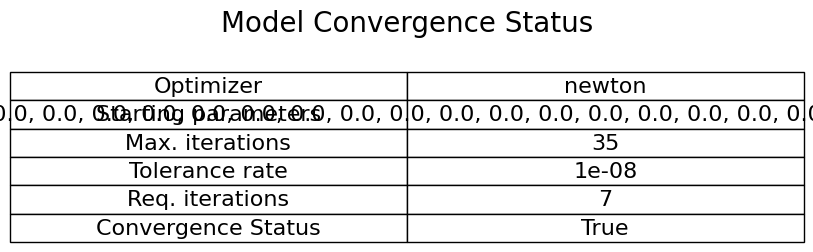

In [ ]:
convergence(y,binned_model_res)

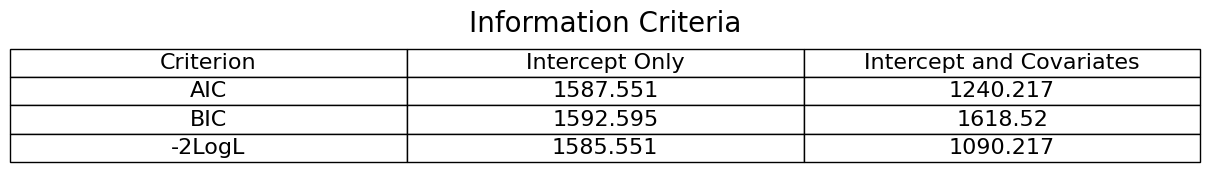

In [ ]:
informationcriteria(y,binned_model_res)

In [ ]:
print(binned_model_res.summary())

                              Logit Regression Results                             
Dep. Variable:     binary_job_satisfaction   No. Observations:                 1146
Model:                               Logit   Df Residuals:                     1071
Method:                                MLE   Df Model:                           74
Date:                     Sun, 10 Mar 2024   Pseudo R-squ.:                  0.3124
Time:                             13:35:03   Log-Likelihood:                -545.11
converged:                            True   LL-Null:                       -792.78
Covariance Type:                 nonrobust   LLR p-value:                 1.307e-63
                                                                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------
year_birth>=1985                  

We check which variables are significant at a 95% significance level.

In [ ]:
binned_model_summary = binned_model_res.summary2().tables[1]
significant_vars = binned_model_summary[binned_model_summary['P>|z|'] < 0.05]
print(significant_vars)

                                                       Coef.  Std.Err.  \
how_emotionally_attached_country_Low               -0.869881  0.347817   
how_emotionally_attached_country_Medium            -0.450881  0.220235   
how_happy_Low                                      -1.006973  0.426908   
how_happy_Medium                                   -0.631488  0.214672   
how_happy_Very High                                 0.974523  0.212490   
line_manager_gives_workrelated_help_likely_Very...  0.471761  0.198813   
line_manager_gives_workrelated_help_likely_High    -0.616119  0.300419   
line_manager_gives_workrelated_help_likely_Very... -1.334504  0.544382   
line_manager_supports_employees_balancing_work_... -0.649387  0.253769   
number_people_living_regularly_member_household... -0.393360  0.175243   
partner_family_fed_pressure_job_often_Very Low      0.868599  0.244469   
partner_family_fed_pressure_job_often_Low           0.695864  0.205902   
too_tired_work_enjoy_things_like_home_

We reestimate the new model using only the significant variables.

In [ ]:
significant_var_names = significant_vars.index.tolist()

X_dum_binned_significant = X_dum_binned[significant_var_names]

binned_model_new = sm.Logit(y, X_dum_binned_significant).fit()

print(binned_model_new.summary())

Optimization terminated successfully.
         Current function value: 0.521754
         Iterations 6
                              Logit Regression Results                             
Dep. Variable:     binary_job_satisfaction   No. Observations:                 1146
Model:                               Logit   Df Residuals:                     1126
Method:                                MLE   Df Model:                           19
Date:                     Sun, 10 Mar 2024   Pseudo R-squ.:                  0.2458
Time:                             13:35:05   Log-Likelihood:                -597.93
converged:                            True   LL-Null:                       -792.78
Covariance Type:                 nonrobust   LLR p-value:                 6.095e-71
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

We repeat the step and select only the variables that are significant.

In [ ]:
binned_model_summary = binned_model_new.summary2().tables[1]
significant_vars_new = binned_model_summary[binned_model_summary['P>|z|'] < 0.05]
print(significant_vars_new)

                                                       Coef.  Std.Err.  \
how_emotionally_attached_country_Low               -0.997610  0.324785   
how_emotionally_attached_country_Medium            -0.615945  0.201214   
how_happy_Low                                      -0.972314  0.385784   
how_happy_Medium                                   -0.623935  0.193144   
how_happy_Very High                                 1.008979  0.185943   
line_manager_gives_workrelated_help_likely_Very...  0.709976  0.159654   
line_manager_gives_workrelated_help_likely_High    -0.543085  0.246853   
line_manager_gives_workrelated_help_likely_Very... -1.283299  0.443804   
line_manager_supports_employees_balancing_work_... -0.758074  0.213608   
number_people_living_regularly_member_household... -0.372910  0.151303   
partner_family_fed_pressure_job_often_Very Low      1.195989  0.191237   
partner_family_fed_pressure_job_often_Low           0.860596  0.168838   
too_tired_work_enjoy_things_like_home_

We reestimate the model.

In [ ]:
new_significant_var_names = significant_vars_new.index.tolist()
X_dum_binned_significant_new = X_dum_binned[new_significant_var_names]

binned_model_new_version = sm.Logit(y, X_dum_binned_significant_new).fit()

print(binned_model_new_version.summary())

Optimization terminated successfully.
         Current function value: 0.521754
         Iterations 6
                              Logit Regression Results                             
Dep. Variable:     binary_job_satisfaction   No. Observations:                 1146
Model:                               Logit   Df Residuals:                     1126
Method:                                MLE   Df Model:                           19
Date:                     Sun, 10 Mar 2024   Pseudo R-squ.:                  0.2458
Time:                             13:35:05   Log-Likelihood:                -597.93
converged:                            True   LL-Null:                       -792.78
Covariance Type:                 nonrobust   LLR p-value:                 6.095e-71
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

### 2.1.5. Model Validation

In [ ]:
# Model Convergence Status: We need to make sure that the log-likelihood function reaches its maximum (See 1. Binary Response Models).
# 2. Testing Global Null Hypothesis: We need to ensure that the model (with the selected set of covariates obtained from Stages 2-3-4) is statistically more relevant than the model without any covariates (See 3. Testing One or Multiple Parameters).
# 3. Information Criteria: We need to ensure that the model (with the selected set of covariates obtained from Stages 2-3-4) has more explanatory power than the model with only the intercept. (see 5. Goodness of Fit Statistics).
# 4. check if removed variables in model 5 are better included than ommitted if coefficients change by a lot

None

None

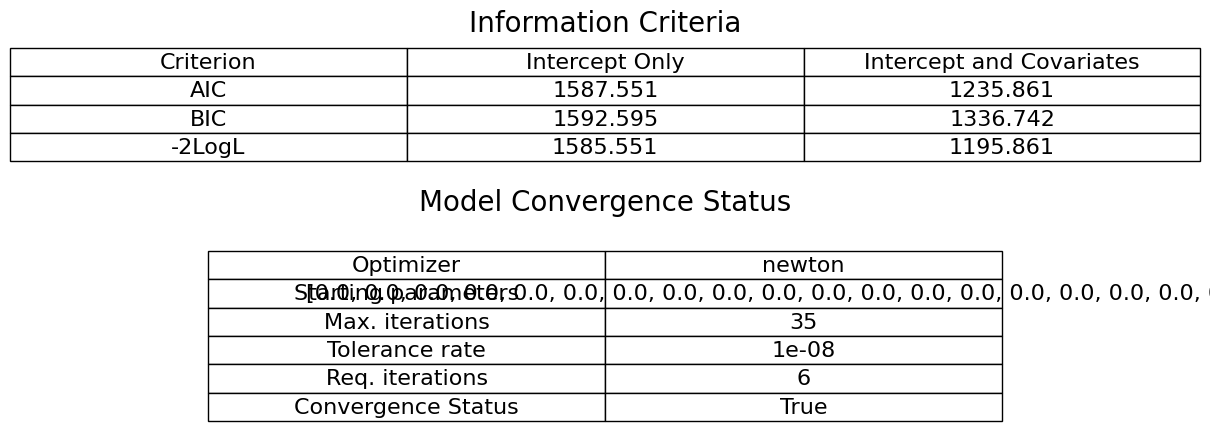

In [ ]:
display(convergence(y,binned_model_new_version))
display(informationcriteria(y, binned_model_new_version))

We see that both AIC and BIC are lower for Model with Intercept and Covariates. This model is statistically more relevant than the model without any covariates.

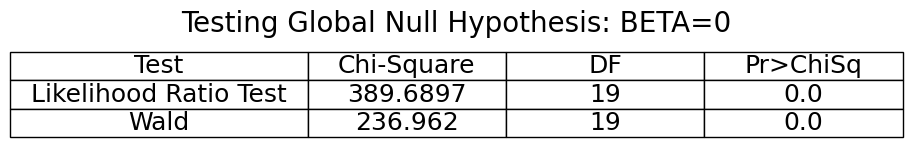

In [ ]:
globalnull(y, binned_model_new_version)

We see that p-value of 0.0 indicates that there is a statistically significant relationship between the predictors and the response variable in our model.This suggests that the predictors in the model have a statistically significant effect on the response variable.



## 2.2 **Model 2 : Creating interaction variables**

### 2.2.1 Create a Richer Set of Covariates

#### (a) Non-linear Effects

In [ ]:
# we can draw relationship plots between explanatory variables and dependent var to see what type of relationship they have.
# add square and cube effects, logarithms, exponential...

In [ ]:
"""We enrich the set of covariates with non linear effects (square and cube effects).
Note that it is possible to consider additional functions such as exponential, inverse,
logarithm, etc."""


# log_eff_num=np.log(X_num).rename(columns=dict(zip(list(X_num.columns),
#                                                   [i+'_log' for i in X_num.columns])))
# log_eff_num.replace([np.inf, -np.inf], 0, inplace=True)

square_eff_num=np.power(X_num, 2).rename(columns=dict(zip(list(X_num.columns),
                                                         [i+'_square' for i in X_num.columns])))
cube_eff_num =np.power(X_num, 3).rename(columns=dict(zip(list(X_num.columns),
                                                         [i+'_cube' for i in X_num.columns])))

#### (b) Interaction Effects

In [ ]:
## think about added effect if variables are grouped together, for example age x revenue impact on credit risk

In [ ]:
"""We enrich the set of covariates with two-level interaction effects for the numeric and ordinal covariates.
Note that we can consider three-level intercation effects and we can also construct the
interaction effects based on the non-linear transformation above... It will lead to get more
that 1000 variable candidates which can be handled as well."""

""" The interaction effect are also built between numeric and nominal covariates to reveal complex
risk factors of borrowers explaining the dependent variable"""

poly = PolynomialFeatures(degree=2,interaction_only=True,include_bias=False)
numeric_onelevelcovariates= X_num

""" Construction of the interaction effect on the set of covariates"""
numeric_oneandtwolevelscovariates=poly.fit_transform(numeric_onelevelcovariates)
numeric_oneandtwolevelscovariates = pd.DataFrame(numeric_oneandtwolevelscovariates,
                                                 columns=poly.get_feature_names_out(numeric_onelevelcovariates.columns)
                                                 )

numeric_twolevelscovariates = numeric_oneandtwolevelscovariates.iloc[:,numeric_onelevelcovariates.shape[1]:]


## Nominal data

nominal_onelevelcovariates = pd.concat([X_nom1, X_nom2], axis=1)
display(nominal_onelevelcovariates.head())

""" Construction of the interaction effect on the set of covariates"""
poly2 = PolynomialFeatures(degree=2,interaction_only=True,include_bias=False)
nominal_oneandtwolevelscovariates=poly2.fit_transform(nominal_onelevelcovariates)

nominal_oneandtwolevelscovariates = pd.DataFrame(nominal_oneandtwolevelscovariates,
                                                 columns=poly2.get_feature_names_out(nominal_onelevelcovariates.columns))

nominal_twolevelscovariates = nominal_oneandtwolevelscovariates.iloc[:, nominal_onelevelcovariates.shape[1]:]
display(nominal_twolevelscovariates.head())

doing_last__days_unemployed_actively_looking_job_0_Not marked  \
0                                                  1               
1                                                  1               
2                                                  1               
3                                                  1               
4                                                  1               

   doing_last__days_unemployed_actively_looking_job_1_Marked  \
0                                                  0           
1                                                  0           
2                                                  0           
3                                                  0           
4                                                  0           

   ever_unemployed_seeking_work_period_three_months_1_Yes  \
0                                                  0        
1                                                  1        
2                                                  0        
3                                                  1        
4                                                  0        

   ever_unemployed_seeking_work_period_three_months_2_No  \
0                                                  1       
1                                                  0       
2                                                  1       
3                                                  0       
4                                                  1       

   partner_last__days_housework_looking_children_others_0_Not marked  \
0                                                  1                   
1                                                  1                   
2                                                  1                   
3                                                  1                   
4                                                  1                   

   partner_last__days_housework_looking_children_others_1_Marked  \
0                                                  0               
1                                                  0               
2                                                  0               
3                                                  0               
4                                                  0               

   doing_last__days_paid_work_0_Not marked  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   doing_last__days_paid_work_1_Marked  citizen_country_1_Yes  \
0                                    1                      1   
1                                    1                      1   
2                                    1                      1   
3                                    1                      1   
4                                    1                      1   

   citizen_country_2_No  ...  \
0                     0  ...   
1                     0  ...   
2                     0  ...   
3                     0  ...   
4                     0  ...   

   industry_nace_rev_Transportation and Miscellaneous  \
0                                                  0    
1                                                  0    
2                                                  0    
3                                                  0    
4                                                  0    

   highest_level_education_spain_Higher Education and Doctorate  \
0                                                  1              
1                                                  1              
2                                                  1              
3                                                  1              
4                                                  1              

   highest_level_education_spain

doing_last__days_unemployed_actively_looking_job_0_Not marked doing_last__days_unemployed_actively_looking_job_1_Marked  \
0                                                0.0                                                                         
1                                                0.0                                                                         
2                                                0.0                                                                         
3                                                0.0                                                                         
4                                                0.0                                                                         

   doing_last__days_unemployed_actively_looking_job_0_Not marked ever_unemployed_seeking_work_period_three_months_1_Yes  \
0                                                0.0                                                                      
1                                                1.0                                                                      
2                                                0.0                                                                      
3                                                1.0                                                                      
4                                                0.0                                                                      

   doing_last__days_unemployed_actively_looking_job_0_Not marked ever_unemployed_seeking_work_period_three_months_2_No  \
0                                                1.0                                                                     
1                                                0.0                                                                     
2                                                1.0                                                                     
3                                                0.0                                                                     
4                                                1.0                                                                     

   doing_last__days_unemployed_actively_looking_job_0_Not marked partner_last__days_housework_looking_children_others_0_Not marked  \
0                                                1.0                                                                                 
1                                                1.0                                                                                 
2                                                1.0                                                                                 
3                                                1.0                                                                                 
4                                                1.0                                                                                 

   doing_last__days_unemployed_actively_looking_job_0_Not marked partner_last__days_housework_looking_children_others_1_Marked  \
0                                                0.0                                                                             
1                                                0.0                                                                             
2                                                0.0                                                                             
3                                                0.0                                                                             
4                                                0.0                                                                             

   doing_last__days_unemployed_actively_looking_job_0_Not marked doing_last__days_paid_work_0_Not marked  \
0                                                0.0                            

In [ ]:
Totalcandidates = X_num.shape[1] + \
                  X_ord.shape[1]+ \
                  square_eff_num.shape[1]+ \
                  cube_eff_num.shape[1]+ \
                  numeric_twolevelscovariates.shape[1]+ \
                  nominal_twolevelscovariates.shape[1]+\
                  X_nom1.shape[1] +\
                  X_nom2.shape[1]
Totalcandidates

2831

In [ ]:
N = y_true.shape[0]
K = Totalcandidates

print("K/N ratio is :", K * 100 / N)

if K/N < 0.15:
    print("No need of variable selection")
else:
    print("Need to select variables and check for multicollinearity")

K/N ratio is : 247.03315881326353
Need to select variables and check for multicollinearity


### 2.2.2. Variable Selection


In [ ]:
## We test if the correlation between the dependent variable y and each explanatory variable x1, x2, ... is statistically significant at a given significance level α
#x/y Parametric tests Non parametric tests

# Numeric / Nominal One-way ANOVA test Kruskal-Wallis test
# Ordinal / Nominal One-way ANOVA test Kruskal-Wallis test
# Nominal / Nominal Chi-Square test of independence Fisher’s exact test

# K/N < 15%

In [ ]:
from sklearn.preprocessing import StandardScaler

numeric_covariates = pd.concat([X_num, square_eff_num, numeric_twolevelscovariates], axis=1)

ordinal_covariates = pd.concat([X_ord], axis=1)

reduced_covariates = []

for covariates in [numeric_covariates, ordinal_covariates]:
    resfull = np.empty((covariates.shape[1],1))
    for i in range(0, covariates.shape[1]):
        res = stats.spearmanr(y_true, covariates.iloc[:,i],alternative='two-sided')
        resfull[i]=res.pvalue

    ayo=np.ravel(resfull<0.05)
    reduced=covariates.iloc[:,ayo]
    reduced_covariates.append(reduced)

numeric_reduced_covariates = reduced_covariates[0]
ordinal_reduced_covariates = reduced_covariates[1]

print("Numeric Co-variates before and after Spearman test", numeric_covariates.shape, numeric_reduced_covariates.shape)
print("Ordinal Co-variates before and after Spearman test", ordinal_covariates.shape, ordinal_reduced_covariates.shape)

Numeric Co-variates before and after Spearman test (1146, 14) (1146, 2)
Ordinal Co-variates before and after Spearman test (1146, 38) (1146, 26)


In [ ]:
nominal_covariates = pd.concat([X_nom1, X_nom2, nominal_twolevelscovariates], axis=1)

resfull = np.empty((nominal_covariates.shape[1],1))
for i in range(0, nominal_covariates.shape[1]):
    crosstab_ = pd.crosstab(y_true, nominal_covariates.iloc[:,i])
    res = stats.chi2_contingency(crosstab_)
    resfull[i]=res.pvalue

ayo=np.ravel(resfull<0.01)  ## with 99% confidence
reduced=nominal_covariates.iloc[:,ayo]

nominal_reduced_covariates = reduced

print("Nominal Co-variates before and after Spearman test", nominal_covariates.shape, nominal_reduced_covariates.shape)

Nominal Co-variates before and after Spearman test (1146, 2775) (1146, 475)


In [ ]:
all_reduced_covariates = pd.concat([numeric_reduced_covariates,
                                    ordinal_reduced_covariates,
                                    nominal_reduced_covariates], axis=1)
all_reduced_covariates.head()

age_respondent_calculated years_fulltime_education_completed  \
0                                              469.0              
1                                              570.0              
2                                              986.0              
3                                             1120.0              
4                                             1247.0              

   age_respondent_calculated total_hours_normally_worked_per_week_main_job_overtime_included  \
0                                         444.427722                                           
1                                         360.499653                                           
2                                         375.882961                                           
3                                         331.300468                                           
4                                         333.076568                                           

   employment_relation  allowed_decide_daily_work_organised  \
0                    1                                   10   
1                    1                                    8   
2                    2                                   10   
3                    1                                    9   
4                    1                                   10   

   work_home_place_choice_often  \
0                             5   
1                             6   
2                             3   
3                             2   
4                             1   

   job_prevents_giving_time_partner_family_often  \
0                                              2   
1                                              4   
2                                              4   
3                                              2   
4                                              1   

   partner_family_fed_pressure_job_often  how_emotionally_attached_country  \
0                                      2                                10   
1                                      4                                 9   
2                                      3                                 9   
3                                      2                                 9   
4                                      1                                10   

   how_happy  employees_expected_responsive_outside_working_hours_often  ...  \
0          9                                                  3          ...   
1          2                                                  3          ...   
2          8                                                  5          ...   
3          9                                                  6          ...   
4         10                                                  1          ...   

   industry_nace_rev_Transportation and Miscellaneous highest_level_education_spain_Higher Education and Doctorate  \
0                                                0.0                                                                 
1                                                0.0                                                                 
2                                                0.0                                                                 
3                                                0.0                                                                 
4                                                0.0                                                                 

   industry_nace_rev_Transportation and Miscellaneous highest_level_education_spain_Secondary Education and Vocational Training  \
0                                                0.0                                                                              
1                                                0.0                                                                              
2                                                0.0                

In [ ]:
N = y_true.shape[0]
K = all_reduced_covariates.shape[1]

print("K/N ratio is :", K * 100 / N)

K/N ratio is : 43.89179755671902


### 2.2.3. Checking for Multicollinearity

In [ ]:
# check if covariates are correlated with each other
# remove one of covariates if κ = 0.9 can choose other threshholds too
# xi/xj Parametric correlation Non parametric correlation
# Numeric / Numeric Pearson correlation coefficient Spearman or Kendall’s coefficients
# Numeric / Ordinal Pearson correlation coefficient Spearman or Kendall’s coefficients
# Numeric / Nominal − −
# Ordinal / Ordinal Pearson correlation coefficient Spearman or Kendall’s coefficients
# Ordinal / Nominal − −
# Nominal / Nominal Cramer’s V

In [ ]:
# If number of covariates is more than 15 % K/N < 15% do this
# 1. Reduce the set of new covariates in Stage 2 (Create a Richer Set of Covariates).
# 2. Reduce the significance level α in Stage 3 (Variable Selection),
# 3. Reduce the threshold κ for correlation in Stage 4 (Multicollinearity Issue).

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tqdm import tqdm

vif_data = pd.DataFrame()
vif_data["Variable"] = all_reduced_covariates.columns

VIF_values = []
for i in tqdm(range(all_reduced_covariates.shape[1])):
    VIF_values.append(variance_inflation_factor(all_reduced_covariates.values, i))

vif_data['VIF'] =VIF_values
vif_data

100%|██████████| 503/503 [05:22<00:00,  1.56it/s]


Variable        VIF
0    age_respondent_calculated years_fulltime_educa...   2.055081
1    age_respondent_calculated total_hours_normally...   2.055613
2                                  employment_relation   3.517525
3                  allowed_decide_daily_work_organised   2.878805
4                         work_home_place_choice_often   2.151569
..                                                 ...        ...
498  highest_level_education_spain_Higher Education...        inf
499  highest_level_education_spain_Higher Education...  49.502355
500  highest_level_education_spain_Secondary Educat...        inf
501  region_Northern and Central Regions highest_le...  10.872876
502  region_Southern Regions highest_level_educatio...  17.641617

[503 rows x 2 columns]

In [ ]:
vif_data_threshold = 10

selected_variables = vif_data[vif_data['VIF'] < vif_data_threshold]['Variable'].to_list()
reduced_subset = all_reduced_covariates[selected_variables]
reduced_subset.shape

(1146, 100)

In [ ]:
print(all_reduced_covariates.shape, reduced_subset.shape)

N = y_true.shape[0]
K = reduced_subset.shape[1]

print("K/N ratio is :", K * 100 / N)

(1146, 503) (1146, 100)
K/N ratio is : 8.726003490401396


### 2.2.4. Model Estimation

Iteration 1

In [ ]:
# Build 3 distinct models
# Write explicitly the model specifications (equations) that have been retained (Models A, B, C, ...).
# Remove variables that are significant p-value

In [ ]:
#To fit a Probit Model

logit_mod = sm.Logit(y_true_df, reduced_subset)
logit_res = logit_mod.fit(maxiter=1000)
print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.479732
         Iterations 144
                              Logit Regression Results                             
Dep. Variable:     binary_job_satisfaction   No. Observations:                 1146
Model:                               Logit   Df Residuals:                     1046
Method:                                MLE   Df Model:                           99
Date:                     Sun, 10 Mar 2024   Pseudo R-squ.:                  0.3065
Time:                             14:50:36   Log-Likelihood:                -549.77
converged:                            True   LL-Null:                       -792.78
Covariance Type:                 nonrobust   LLR p-value:                 2.116e-52
                                                                                                                                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------

In [ ]:
## Removing variables with significant p-value

# Get p-values for each variable
p_values = logit_res.pvalues

# Filter variables with p-value < 0.05
insignificant_variables = p_values[p_values >= 0.05].index
significant_variables = p_values[p_values < 0.05].index

Iteration 2

In [ ]:
#To fit a Probit Model
logit_mod_new_version = sm.Logit(y_true_df, reduced_subset[significant_variables])
logit_res_new_version = logit_mod_new_version.fit(maxiter=10000)
print(logit_res_new_version.summary())

Optimization terminated successfully.
         Current function value: 0.557186
         Iterations 6
                              Logit Regression Results                             
Dep. Variable:     binary_job_satisfaction   No. Observations:                 1146
Model:                               Logit   Df Residuals:                     1137
Method:                                MLE   Df Model:                            8
Date:                     Sun, 10 Mar 2024   Pseudo R-squ.:                  0.1946
Time:                             14:50:36   Log-Likelihood:                -638.53
converged:                            True   LL-Null:                       -792.78
Covariance Type:                 nonrobust   LLR p-value:                 6.444e-62
                                                                                                        coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------

In [ ]:
## Removing variables with significant p-value

# Get p-values for each variable
p_values_iter2 = logit_res_new_version.pvalues

# Filter variables with p-value < 0.05
insignificant_variables_iter2 = p_values_iter2[p_values_iter2 >= 0.05].index
significant_variables_iter2 = p_values_iter2[p_values_iter2 < 0.05].index

Iteration 3

We repeat the step and select only the variables that are significant.

In [ ]:
#To fit a Probit Model
logit_mod_new_version = sm.Logit(y_true_df, reduced_subset[significant_variables_iter2])
logit_res_new_version = logit_mod_new_version.fit(maxiter=1000)
print(logit_res_new_version.summary())

Optimization terminated successfully.
         Current function value: 0.557289
         Iterations 6
                              Logit Regression Results                             
Dep. Variable:     binary_job_satisfaction   No. Observations:                 1146
Model:                               Logit   Df Residuals:                     1138
Method:                                MLE   Df Model:                            7
Date:                     Sun, 10 Mar 2024   Pseudo R-squ.:                  0.1944
Time:                             14:50:36   Log-Likelihood:                -638.65
converged:                            True   LL-Null:                       -792.78
Covariance Type:                 nonrobust   LLR p-value:                 1.049e-62
                                                                                                        coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------

### 2.2.5. Model Validation

In [ ]:
# Model Convergence Status: We need to make sure that the log-likelihood function reaches its maximum (See 1. Binary Response Models).
# 2. Testing Global Null Hypothesis: We need to ensure that the model (with the selected set of covariates obtained from Stages 2-3-4) is statistically more relevant than the model without any covariates (See 3. Testing One or Multiple Parameters).
# 3. Information Criteria: We need to ensure that the model (with the selected set of covariates obtained from Stages 2-3-4) has more explanatory power than the model with only the intercept. (see 5. Goodness of Fit Statistics).
# 4. check if removed variables in model 5 are better included than ommitted if coefficients change by a lot

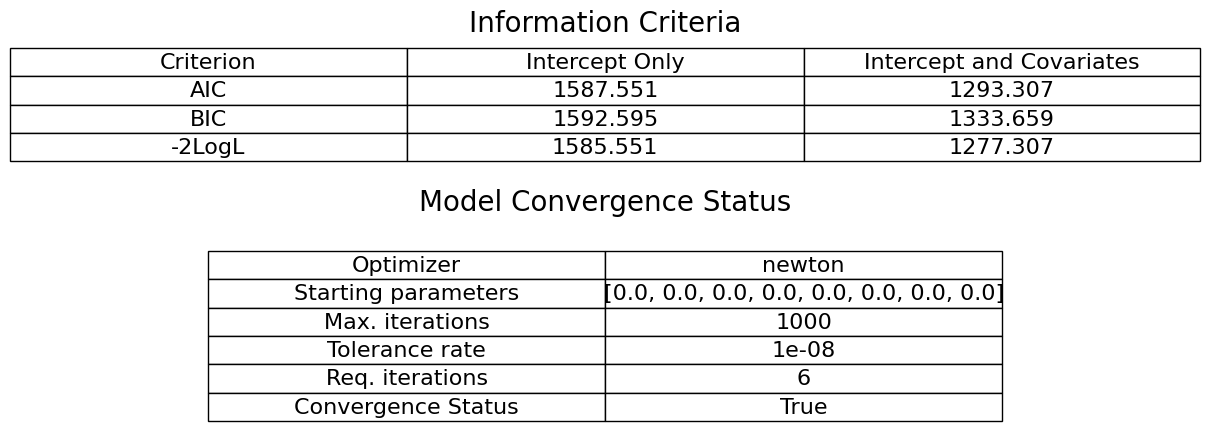

In [ ]:
convergence(y_true_df, logit_res_new_version)
informationcriteria(y_true_df, logit_res_new_version)

We see that both AIC and BIC are lower for Model with Intercept and Covariates. This model is statistically more relevant than the model without any covariates.

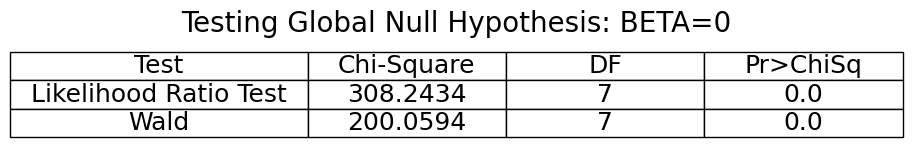

In [ ]:
globalnull(y_true_df, logit_res_new_version)

We see that p-value of 0.0 indicates that there is a statistically significant relationship between the predictors and the response variable in our model.This suggests that the predictors in the model have a statistically significant effect on the response variable.

## 2.3. **Model 3 : Original variables with transformations**

### 2.3.1 Create a Richer Set of Covariates

#### (a) Non-linear Effects

In [ ]:
square_eff_num=np.power(X_num, 2)
cube_eff_num =np.power(X_num, 3)
log_eff_num = np.log(X_num)
exp_eff_num = np.exp(X_num)

In [ ]:
renamed_dict_2 = {col: col + "_2" for col in square_eff_num.columns}
renamed_dict_3 = {col: col + "_3" for col in square_eff_num.columns}
renamed_dict_log = {col: "log_"+ col for col in square_eff_num.columns}
renamed_dict_exp = {col: "exp_"+ col for col in square_eff_num.columns}

# Dropping few columns because of log/ exp of features produced infinity/Nan values
square_eff_num = (square_eff_num.drop(columns=['year_birth'])
                           .rename(columns=renamed_dict_2))
cube_eff_num = (cube_eff_num.drop(columns=['year_birth'])
                           .rename(columns=renamed_dict_3))
log_eff_num = (log_eff_num.drop(columns = ['years_fulltime_education_completed','total_hours_normally_worked_per_week_main_job_overtime_included'])
                           .rename(columns=renamed_dict_log)              )
exp_eff_num = (exp_eff_num.drop(columns = ['year_birth','age_respondent_calculated','years_fulltime_education_completed'])
                           .rename(columns=renamed_dict_exp))

In [ ]:
X_num_with_transformations = pd.concat([X_num,square_eff_num,cube_eff_num,log_eff_num,exp_eff_num],axis=1)
X_num_with_transformations.head()

year_birth  age_respondent_calculated  years_fulltime_education_completed  \
0      1955.0                       67.0                                 7.0   
1      1965.0                       57.0                                10.0   
2      1964.0                       58.0                                17.0   
3      1966.0                       56.0                                20.0   
4      1979.0                       43.0                                29.0   

   total_hours_normally_worked_per_week_main_job_overtime_included  \
0                                           6.633250                 
1                                           6.324555                 
2                                           6.480741                 
3                                           5.916080                 
4                                           7.745967                 

   age_respondent_calculated_2  years_fulltime_education_completed_2  \
0                       4489.0                                  49.0   
1                       3249.0                                 100.0   
2                       3364.0                                 289.0   
3                       3136.0                                 400.0   
4                       1849.0                                 841.0   

   total_hours_normally_worked_per_week_main_job_overtime_included_2  \
0                                               44.0                   
1                                               40.0                   
2                                               42.0                   
3                                               35.0                   
4                                               60.0                   

   age_respondent_calculated_3  years_fulltime_education_completed_3  \
0                     300763.0                                 343.0   
1                     185193.0                                1000.0   
2                     195112.0                                4913.0   
3                     175616.0                                8000.0   
4                      79507.0                               24389.0   

   total_hours_normally_worked_per_week_main_job_overtime_included_3  \
0                                         291.862982                   
1                                         252.982213                   
2                                         272.191109                   
3                                         207.062792                   
4                                         464.758002                   

   log_year_birth  log_age_respondent_calculated  \
0        7.578145                       4.204693   
1        7.583248                       4.043051   
2        7.582738                       4.060443   
3        7.583756                       4.025352   
4        7.590347                       3.761200   

   exp_total_hours_normally_worked_per_week_main_job_overtime_included  
0                                         759.947674                    
1                                         558.109578                    
2                                         652.454039                    
3                                         370.954637                    
4                                        2312.227657

In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardize the numerical features
scaler = StandardScaler()
standardized_numerical = scaler.fit_transform(X_num_with_transformations)

# Concatenate standardized numerical features with nominal features
X_num_with_transformations = pd.DataFrame(standardized_numerical, columns=X_num_with_transformations.columns)
X_num_with_transformations.head()

year_birth  age_respondent_calculated  years_fulltime_education_completed  \
0   -1.891194                   1.891194                           -1.269435   
1   -1.018124                   1.018124                           -0.777087   
2   -1.105431                   1.105431                            0.371725   
3   -0.930817                   0.930817                            0.864073   
4    0.204175                  -0.204175                            2.341118   

   total_hours_normally_worked_per_week_main_job_overtime_included  \
0                                           0.551563                 
1                                           0.424047                 
2                                           0.488564                 
3                                           0.255314                 
4                                           1.011205                 

   age_respondent_calculated_2  years_fulltime_education_completed_2  \
0                     2.264109                             -1.155128   
1                     1.044637                             -0.868101   
2                     1.157734                              0.195586   
3                     0.933508                              0.820291   
4                    -0.332185                              3.302228   

   total_hours_normally_worked_per_week_main_job_overtime_included_2  \
0                                           0.602438                   
1                                           0.363154                   
2                                           0.482796                   
3                                           0.064049                   
4                                           1.559574                   

   age_respondent_calculated_3  years_fulltime_education_completed_3  \
0                     2.625169                             -0.924274   
1                     1.029148                             -0.787559   
2                     1.166129                              0.026696   
3                     0.896890                              0.669069   
4                    -0.430375                              4.079450   

   total_hours_normally_worked_per_week_main_job_overtime_included_3  \
0                                           0.607563                   
1                                           0.281764                   
2                                           0.442724                   
3                                          -0.103015                   
4                                           2.056327                   

   log_year_birth  log_age_respondent_calculated  \
0       -1.900036                       1.528445   
1       -1.018940                       0.949507   
2       -1.106848                       1.011798   
3       -0.931078                       0.886114   
4        0.207090                      -0.059975   

   exp_total_hours_normally_worked_per_week_main_job_overtime_included  
0                                           0.383501                    
1                                          -0.031380                    
2                                           0.162546                    
3                                          -0.416079                    
4                                           3.574230

In [ ]:
X_dataset = pd.concat([X_num_with_transformations, X_nom1, X_nom2, X_ord],axis=1)
X_dataset.head()

year_birth  age_respondent_calculated  years_fulltime_education_completed  \
0   -1.891194                   1.891194                           -1.269435   
1   -1.018124                   1.018124                           -0.777087   
2   -1.105431                   1.105431                            0.371725   
3   -0.930817                   0.930817                            0.864073   
4    0.204175                  -0.204175                            2.341118   

   total_hours_normally_worked_per_week_main_job_overtime_included  \
0                                           0.551563                 
1                                           0.424047                 
2                                           0.488564                 
3                                           0.255314                 
4                                           1.011205                 

   age_respondent_calculated_2  years_fulltime_education_completed_2  \
0                     2.264109                             -1.155128   
1                     1.044637                             -0.868101   
2                     1.157734                              0.195586   
3                     0.933508                              0.820291   
4                    -0.332185                              3.302228   

   total_hours_normally_worked_per_week_main_job_overtime_included_2  \
0                                           0.602438                   
1                                           0.363154                   
2                                           0.482796                   
3                                           0.064049                   
4                                           1.559574                   

   age_respondent_calculated_3  years_fulltime_education_completed_3  \
0                     2.625169                             -0.924274   
1                     1.029148                             -0.787559   
2                     1.166129                              0.026696   
3                     0.896890                              0.669069   
4                    -0.430375                              4.079450   

   total_hours_normally_worked_per_week_main_job_overtime_included_3  ...  \
0                                           0.607563                  ...   
1                                           0.281764                  ...   
2                                           0.442724                  ...   
3                                          -0.103015                  ...   
4                                           2.056327                  ...   

   speak_line_manager_work_person_often  \
0                                     3   
1                                     6   
2                                     3   
3                                     1   
4                                     3   

   allowed_influence_policy_decisions_activities_organisation  \
0                                                  9            
1                                                  5            
2                                                 10            
3                                                  6            
4                                                  9            

   take_part_social_activities_compared_others_age  \
0                                                4   
1                                                1   
2                                                2   
3                                                1   
4                                                4   

   how_many_people_discuss_intimate_personal_matters  \
0                                                  5   
1                                                  1   
2                                                  1   
3                                                  3   
4                                                  2   

   too_tired_work_enjoy_thi

In [ ]:
# K/n ratio
n = X_dataset.shape[0]
K = X_dataset.shape[1]
# print(K)
print(f'The K/n ratio is :{100*K/n:.3f}')

The K/n ratio is :10.908


### 2.3.2. Variable Selection

In [ ]:
from scipy.stats import chi2_contingency

chi2_res = np.empty(X_dataset.shape[1])

for i in range(X_dataset.shape[1]):
    contingency_table = pd.crosstab(y_true, X_dataset.iloc[:, i])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi2_res[i] = p

chi2_ayo = np.ravel(chi2_res < 0.05)
reduced_X_dataset = X_dataset.iloc[:, chi2_ayo]
print(f'The shape of dataset before selection: {X_dataset.shape}')
print(f'The shape of dataset after selection: {reduced_X_dataset.shape}')


The shape of dataset before selection: (1146, 125)
The shape of dataset after selection: (1146, 47)


In [ ]:
# K/n ratio
n = reduced_X_dataset.shape[0]
K = reduced_X_dataset.shape[1]
# print(K)
print(f'The K/n ratio after variable selection is : {100*K/n:.3f}')

The K/n ratio after variable selection is : 4.101


### 2.3.3. Checking for Multicollinearity

In [ ]:
# Double Checking Multicolliearity using VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming X_dum_binned is your DataFrame of independent variables
vif_data = pd.DataFrame()
vif_data["Feature"] = reduced_X_dataset.columns

# Calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(reduced_X_dataset.values, i) for i in range(len(reduced_X_dataset.columns))]

# Display the VIFs
display(vif_data)
print("================================================================================================================")

columns_to_keep_after_VIF = list(vif_data[vif_data["VIF"]<10]["Feature"])
# print(columns_to_keep_after_VIF)
print(f'The number of columns to keep after VIF: {len(columns_to_keep_after_VIF)}')

print("================================================================================================================")

Feature        VIF
0   doing_last__days_unemployed_actively_looking_j...        inf
1   doing_last__days_unemployed_actively_looking_j...        inf
2           partner_last__days_paid_work_0_Not marked        inf
3               partner_last__days_paid_work_1_Marked        inf
4   employment_contract_unlimited_limited_duration...   2.029590
5             responsible_supervising_employees_1_Yes  22.959758
6              responsible_supervising_employees_2_No  23.006447
7                        parent_lives_household_1_Yes   1.281607
8   improve_knowledge_skills_course_lecture_confer...  41.760566
9   improve_knowledge_skills_course_lecture_confer...  41.629001
10  occupation_isco_Administrative, Education, and...        inf
11    occupation_isco_Construction and Related Trades        inf
12  occupation_isco_Drivers, Software Developers, ...        inf
13  what_type_organisation_work_worked_Government ...        inf
14   what_type_organisation_work_worked_Miscellaneous        inf
15  what_type_organisation_work_worked_Private Fir...        inf
16   industry_nace_rev_Manufacturing and Construction        inf
17  industry_nace_rev_Services, Health, and Education        inf
18  industry_nace_rev_Transportation and Miscellan...        inf
19  highest_level_education_spain_Higher Education...  30.097379
20  highest_level_education_spain_Secondary Educat...  28.185833
21    region_Basque Country, Navarra, and Extremadura   1.100984
22                region_Northern and Central Regions   1.111113
23  highest_level_education_Higher Education and D...  18.646842
24  highest_level_education_Secondary and Vocation...  17.976776
25                                employment_relation   1.840031
26                allowed_decide_daily_work_organised   1.943840
27      job_prevents_giving_time_partner_family_often   1.795775
28              partner_family_fed_pressure_job_often   1.618482
29                   how_emotionally_attached_country   1.122113
30                                          how_happy   1.253042
31  employees_expected_responsive_outside_working_...   1.147947
32             employees_expected_work_overtime_often   1.382706
33  hampered_daily_activities_illness_disability_i...   1.279761
34                      speak_colleagues_person_often   1.128822
35                          subjective_general_health   1.357088
36          current_job_decide_time_start_finish_work   1.496742
37    number_people_living_regularly_member_household   1.189667
38                 feeling_households_income_nowadays   1.557676
39            colleagues_give_workrelated_help_likely   1.272939
40                households_total_net_income_sources   1.662744
41  allowed_influence_policy_decisions_activities_...   2.156240
42    take_part_social_activities_compared_others_age   1.232803
43  how_many_people_discuss_intimate_personal_matters   1.249931
44        too_tired_work_enjoy_things_like_home_often   1.626360
45         line_manager_gives_workrelated_help_likely   1.650898
46  line_manager_supports_employees_balancing_work...   1.853704

The number of columns to keep after VIF: 26


### 2.3.4. Model Estimation

In [ ]:
X_dataset_1 = reduced_X_dataset.copy()
X_dataset_1 = reduced_X_dataset[columns_to_keep_after_VIF]

In [ ]:
model_3 = sm.Logit(y_true, X_dataset_1).fit(maxiters=1000,tol=1e-6)

Optimization terminated successfully.
         Current function value: 0.540708
         Iterations 6


In [ ]:
print(model_3.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1146
Model:                          Logit   Df Residuals:                     1120
Method:                           MLE   Df Model:                           25
Date:                Sun, 10 Mar 2024   Pseudo R-squ.:                  0.2184
Time:                        14:50:40   Log-Likelihood:                -619.65
converged:                       True   LL-Null:                       -792.78
Covariance Type:            nonrobust   LLR p-value:                 2.803e-58
                                                                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
employment_contract_unlimited_limited_duration_nan                        0.3624      0.260 

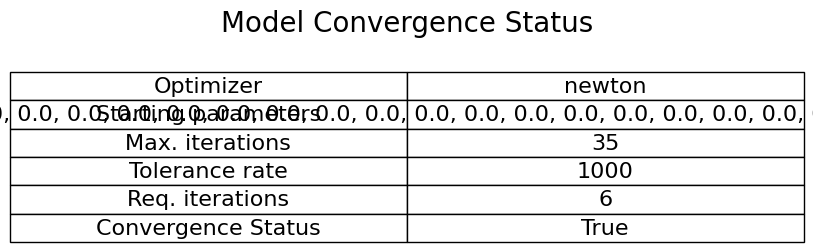

In [ ]:
convergence(y_true,model_3)

Iteration 2 of the model after dropping insignificant variables

In [ ]:
significant_values = model_3.pvalues[model_3.pvalues<0.05]
X_dataset_2 = X_dataset.copy()[list(significant_values.index)]

model_4 = sm.Logit(y_true, X_dataset_2).fit(maxiters=1000,tol=1e-6)
print(model_4.summary())

Optimization terminated successfully.
         Current function value: 0.561449
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1146
Model:                          Logit   Df Residuals:                     1138
Method:                           MLE   Df Model:                            7
Date:                Sun, 10 Mar 2024   Pseudo R-squ.:                  0.1884
Time:                        14:50:40   Log-Likelihood:                -643.42
converged:                       True   LL-Null:                       -792.78
Covariance Type:            nonrobust   LLR p-value:                 1.141e-60
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
parent_lives_household_1_Y

### 2.3.5. Model Validation

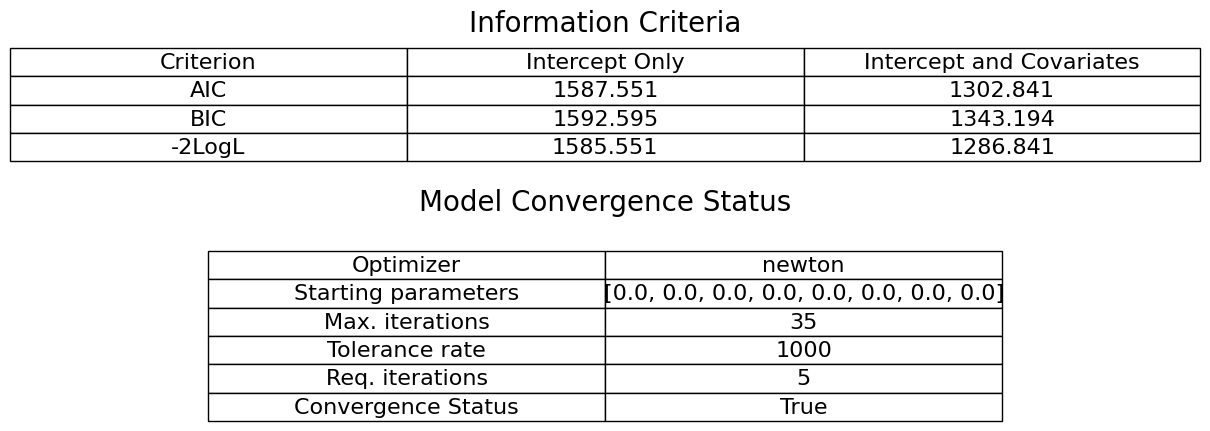

In [ ]:
convergence(y_true,model_4)
informationcriteria(y_true,model_4)

We see that both AIC and BIC are lower for Model with Intercept and Covariates. This model is statistically more relevant than the model without any covariates.

# (3). Model Selection


In [ ]:
# split test train set
# compute performance metrics: AUC, R2, R2 EFRON...
# you can compute PCC-accuracy, number of prediction error, F1 score, ...)
# DO NOT USE PCC to perform the model selection

In [ ]:
model1_x_data = X_dum_binned_significant_new
model1_y_data = y

model2_x_data = reduced_subset[significant_variables_iter2]
model2_y_data = y_true_df

model3_x_data = X_dataset_2
model3_y_data = y_true

## (a). Model 1: Binned Model

### Binned Model Specification

Job satisfaction among a sample of 916 individuals from Spain.

yi ={
*   1 if individual i is satisfied with their job
*   0 otherwise.}



The model reads as,

πi = Λ(β0 + β1 * how_emotionally_attached_country_Low_i + β2 * how_emotionally_attached_country_Medium_i + β3 * how_happy_Low_i + β4 * how_happy_Medium_i + β5 * how_happy_Very_High_i + β6 * line_manager_gives_workrelated_help_likely_Very_Low_i + β7 * line_manager_gives_workrelated_help_likely_High_i + β8 * line_manager_gives_workrelated_help_likely_Very_High_i + β9 * line_manager_supports_employees_balancing_work_much_Medium_i + β10 * number_people_living_regularly_member_household_Very_Low_i + β11 * partner_family_fed_pressure_job_often_Very_Low_i + β12 * partner_family_fed_pressure_job_often_Low_i + β13 * too_tired_work_enjoy_things_like_home_often_Very_High_i + β14 * doing_last__days_unemployed_actively_looking_job_0_Not_marked_i + β15 * responsible_supervising_employees_1_Yes_i + β16 * occupation_isco_Drivers_Software_Developers_and_Miscellaneous_i + β17 * what_type_organisation_work_worked_Miscellaneous_i + β18 * industry_nace_rev_Transportation_and_Miscellaneous_i + β19 * region_Northern_and_Central_Regions_i)

Where:
- πi: Probability of individual i being satisfied with their job.
- Λ: The logistic function applied to binned/nominal covariates.
- β0: Intercept.
- β1 to β19: Coefficients for each of the predictors.
- Predictors include various aspects like emotional attachment to the country, happiness levels, interaction with line managers, household dynamics, work-life balance pressures, tiredness levels due to work, employment status, supervisory responsibilities, occupation categories, type of organisation, industry sectors, and regional factors.

This model was generated from multiple iterations on all binned and categorical variables after thorough variable selection, based on multicollinarity and variable significance.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(model1_x_data, model1_y_data, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
# We verify the proportion of 0 and 1 is same in training and test samples.
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print(counts_elements/len(y_train))
unique_elements, counts_elements = np.unique(y_test, return_counts=True)
print(counts_elements/len(y_test))

[0.52947598 0.47052402]
[0.51304348 0.48695652]


In [ ]:
M1 = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.516036
         Iterations 6


In [ ]:
print(M1.summary())

                              Logit Regression Results                             
Dep. Variable:     binary_job_satisfaction   No. Observations:                  916
Model:                               Logit   Df Residuals:                      896
Method:                                MLE   Df Model:                           19
Date:                     Sun, 10 Mar 2024   Pseudo R-squ.:                  0.2536
Time:                             16:58:08   Log-Likelihood:                -472.69
converged:                            True   LL-Null:                       -633.33
Covariance Type:                 nonrobust   LLR p-value:                 8.533e-57
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
how_emotionally_attached_country_Low                            

In [ ]:
# Predicted probabilities (computed for the test set):
pi_test=M1.predict(X_test)

y_hat    0    1  All
y                   
0       84   34  118
1       35   77  112
All    119  111  230


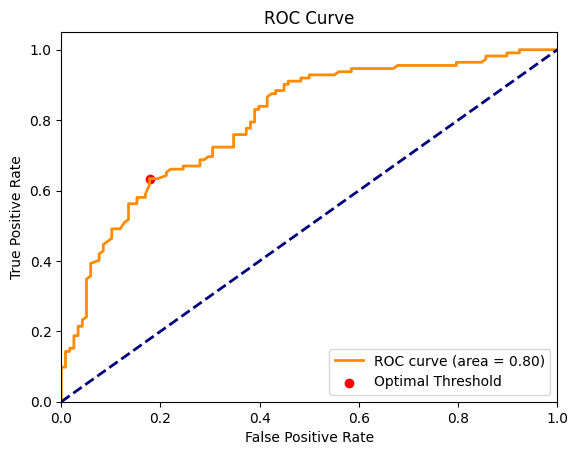

AUC: 0.7970
R2 Efron: 0.2595570010330638
gamma: 0.5 - number of predictions errors: 69 - percentage of correctly classified: 0.7000


In [ ]:
performancemetrics(y_test,pi_test, 0.5)

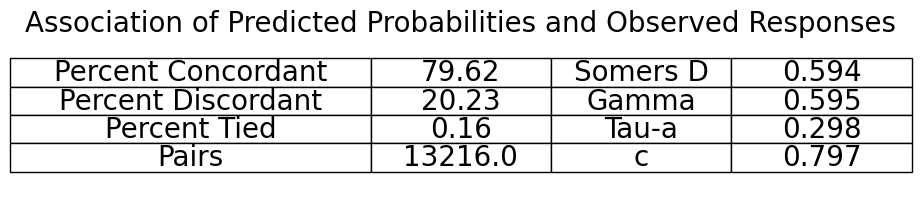

In [ ]:
associationstat(X_test, y_test, M1)

Finding optimal break and computing model performance measures

M1 Optimal Threshold: 0.590205014188407
M1 AUC: 0.7969506658595642
y_hat    0   1  All
y                  
0       97  21  118
1       42  70  112
All    139  91  230


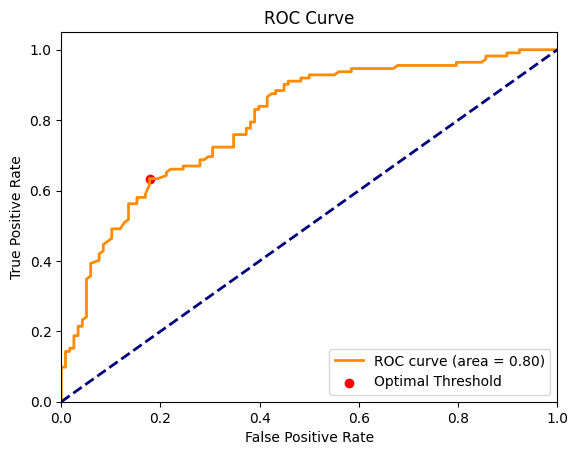

AUC: 0.7970
R2 Efron: 0.2595570010330638
gamma: 0.590205014188407 - number of predictions errors: 63 - percentage of correctly classified: 0.7261


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix

 # Compute ROC curve and AUC

fpr, tpr, thresholds = roc_curve(y_test, pi_test)
M1_roc_auc = auc(fpr, tpr)

# Compute the optimal threshold
M1_optimal_idx = np.argmax(tpr - fpr)
M1_gamma = thresholds[M1_optimal_idx]

print(f"{'M1'} Optimal Threshold: {M1_gamma}")
print(f"{'M1'} AUC: {M1_roc_auc}")

def performancemetrics(y_test, pi_test, gamma):
    # Calculate predictions based on gamma threshold
    y_hatnp = np.where(pi_test > gamma, 1, 0)
    y_hat = pd.DataFrame(y_hatnp, columns=['y_hat'])

    # Convert y_test to DataFrame for consistency in handling
    y_laby = pd.DataFrame(y_test).reset_index(drop=True)
    y_laby.columns = ['y']

    # Concatenate true labels and predictions for confusion matrix
    yyhat = pd.concat([y_laby, y_hat], axis=1)

    # Confusion matrix
    confusion_matrix = pd.crosstab(yyhat.y, yyhat.y_hat, margins=True)
    print(confusion_matrix)

    # ROC curve and AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pi_test, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)

    # Find optimal threshold index
    optimal_idx = np.argmax(tpr - fpr)

    # Plotting ROC curve including the optimal threshold
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label='Optimal Threshold')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC
    print('AUC: %.4f' % roc_auc)

    # Calculate and print R2 Efron
    ynp = np.asarray(y_test).ravel()
    pinp = np.asarray(pi_test).ravel()
    R2Efron = 1 - np.sum((ynp - pinp) ** 2) / np.sum((ynp - np.mean(ynp)) ** 2)
    print('R2 Efron:', R2Efron)

    # Calculate and print the number of prediction errors and percentage of correctly classified instances
    nberrors = np.sum((ynp - y_hatnp) ** 2)
    print('gamma:', gamma, '- number of predictions errors:', nberrors, '- percentage of correctly classified: %.4f' % (1 - nberrors / len(ynp)))

performancemetrics(y_test, pi_test, M1_gamma)

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pi_test, pos_label=1)
M1_auc = str(np.round(metrics.auc(fpr, tpr) * 100, 2)) + '%'
M1_aic = np.round(M1.aic,3)
M1_bic = np.round(M1.bic,3)

ynp = np.asarray(y_test).ravel()
pinp = np.asarray(pi_test).ravel()
M1_R2Efron = np.round(1 - np.sum((ynp - pinp) ** 2) / np.sum((ynp - np.mean(ynp)) ** 2) , 4)
M1_R2 = str(np.round(M1.prsquared * 100 ,2)) + '%'

## (b). Model 2: With interaction variables

### Model with Interaction Terms Specification

Job satisfaction among a sample of 916 individuals from Spain.

yi ={
*   1 if individual i is satisfied with their job
*   0 otherwise.}

The model reads as,

πi = Φ(β0 + β1 * partner_family_fed_pressure_job_often_i + β2 * how_emotionally_attached_country_i + β3 * how_happy_i + β4 * too_tired_work_enjoy_things_like_home_often_i + β5 * line_manager_gives_workrelated_help_likely_i + β6 * line_manager_supports_employees_balancing_work_much_i + β7 * gender_2_Female_region_Basque_Country_Navarra_and_Extremadura_i + β8 * fathers_occupation_respondent_Unskilled_Workers_what_type_organisation_work_worked_Miscellaneous_i)

Where:

- πi: Probability of individual i being satisfied with their job.
- Φ: The cumulative distribution function of the standard normal distribution, reflecting the Probit model.
- β0: Intercept.
- β1 to β8: Coefficients for each of the predictors and interaction terms.
- The predictors include various individual and work-related aspects, such as pressure from partner/family, emotional attachment to the country, happiness levels, tiredness from work, likelihood of receiving work-related help from the line manager, and the line manager's support in balancing work and life.
- Interaction terms account for complex relationships between variables, like the combined effect of gender and region, or the father's occupation and the type of organisation where the respondent worked.

This model was estimated using Maximum Likelihood Estimation (MLE) and focuses on the influence of specific interaction terms along with primary predictors on job satisfaction, indicating a more nuanced approach to understanding the factors contributing to job satisfaction among employees. The model was generated after several iterations testing all interaction terms and reducing using multicollinearity checks and significance of variables.

In [ ]:
# split test train set
# compute performance metrics: AUC, R2, R2 EFRON...
# you can compute PCC-accuracy, number of prediction error, F1 score, ...)
# DO NOT USE PCC to perform the model selection

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(model2_x_data, model2_y_data,
                                                    test_size=0.2, shuffle=True, random_state=42)

In [ ]:
# We verify the proportion of 0 and 1 is same in training and test samples.
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print(counts_elements/len(y_train))
unique_elements, counts_elements = np.unique(y_test, return_counts=True)
print(counts_elements/len(y_test))

[0.52947598 0.47052402]
[0.51304348 0.48695652]


In [ ]:
M2 = sm.Probit(y_train, X_train).fit()
print(M2.summary())

Optimization terminated successfully.
         Current function value: 0.549644
         Iterations 6
                             Probit Regression Results                             
Dep. Variable:     binary_job_satisfaction   No. Observations:                  916
Model:                              Probit   Df Residuals:                      908
Method:                                MLE   Df Model:                            7
Date:                     Sun, 10 Mar 2024   Pseudo R-squ.:                  0.2050
Time:                             16:58:09   Log-Likelihood:                -503.47
converged:                            True   LL-Null:                       -633.33
Covariance Type:                 nonrobust   LLR p-value:                 2.368e-52
                                                                                                        coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------

In [ ]:
# Predicted probabilities (computed for the test set):
pi_test=M2.predict(X_test)

y_hat    0    1  All
y                   
0       85   33  118
1       38   74  112
All    123  107  230


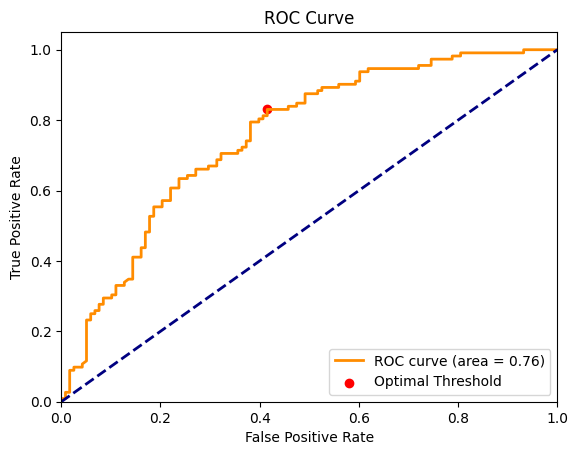

AUC: 0.7552
R2 Efron: 0.18686813243081235
gamma: 0.5 - number of predictions errors: 71 - percentage of correctly classified: 0.6913


In [ ]:
performancemetrics(y_test, pi_test, 0.5)

M2 Optimal Threshold: 0.378381988368963
M2 AUC: 0.7552209443099274
y_hat   0    1  All
y                  
0      69   49  118
1      20   92  112
All    89  141  230


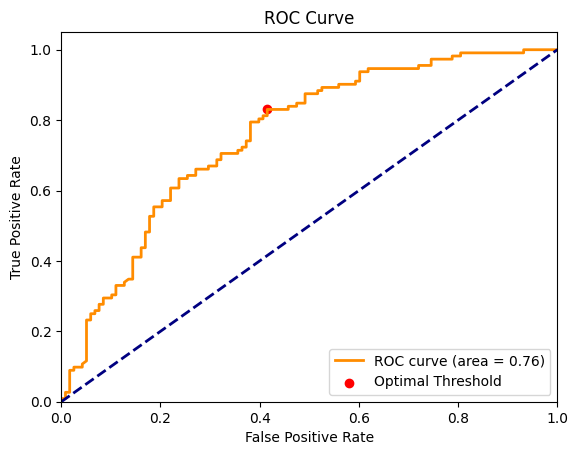

AUC: 0.7552
R2 Efron: 0.18686813243081235
gamma: 0.378381988368963 - number of predictions errors: 69 - percentage of correctly classified: 0.7000


In [ ]:
 # Compute ROC curve and AUC

fpr, tpr, thresholds = roc_curve(y_test, pi_test)
M2_roc_auc = auc(fpr, tpr)

# Compute the optimal threshold
M2_optimal_idx = np.argmax(tpr - fpr)
M2_gamma = thresholds[M2_optimal_idx]

print(f"{'M2'} Optimal Threshold: {M2_gamma}")
print(f"{'M2'} AUC: {M2_roc_auc}")

def performancemetrics(y_test, pi_test, gamma):
    # Calculate predictions based on gamma threshold
    y_hatnp = np.where(pi_test > gamma, 1, 0)
    y_hat = pd.DataFrame(y_hatnp, columns=['y_hat'])

    # Convert y_test to DataFrame for consistency in handling
    y_laby = pd.DataFrame(y_test).reset_index(drop=True)
    y_laby.columns = ['y']

    # Concatenate true labels and predictions for confusion matrix
    yyhat = pd.concat([y_laby, y_hat], axis=1)

    # Confusion matrix
    confusion_matrix = pd.crosstab(yyhat.y, yyhat.y_hat, margins=True)
    print(confusion_matrix)

    # ROC curve and AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pi_test, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)

    # Find optimal threshold index
    optimal_idx = np.argmax(tpr - fpr)

    # Plotting ROC curve including the optimal threshold
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label='Optimal Threshold')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC
    print('AUC: %.4f' % roc_auc)

    # Calculate and print R2 Efron
    ynp = np.asarray(y_test).ravel()
    pinp = np.asarray(pi_test).ravel()
    R2Efron = 1 - np.sum((ynp - pinp) ** 2) / np.sum((ynp - np.mean(ynp)) ** 2)
    print('R2 Efron:', R2Efron)

    # Calculate and print the number of prediction errors and percentage of correctly classified instances
    nberrors = np.sum((ynp - y_hatnp) ** 2)
    print('gamma:', gamma, '- number of predictions errors:', nberrors, '- percentage of correctly classified: %.4f' % (1 - nberrors / len(ynp)))

performancemetrics(y_test, pi_test, M2_gamma)

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pi_test, pos_label=1)
M2_auc = str(np.round(metrics.auc(fpr, tpr) * 100, 2)) + '%'
M2_aic = np.round(M2.aic,3)
M2_bic = np.round(M2.bic,3)

ynp = np.asarray(y_test).ravel()
pinp = np.asarray(pi_test).ravel()
M2_R2Efron = np.round(1 - np.sum((ynp - pinp) ** 2) / np.sum((ynp - np.mean(ynp)) ** 2), 4)
M2_R2 = str(np.round(M2.prsquared * 100 ,2)) + '%'

## (c). Model 3: Original variables with transformations

### Model - Original Variables with Transformations Specification

Job satisfaction among a sample of 916 individuals from Spain.

yi ={
*   1 if individual i is satisfied with their job
*   0 otherwise.}


The model reads as,

πi = Λ(β0 + β1 * parent_lives_household_1_Yes_i + β2 * region_Basque_Country_Navarra_and_Extremadura_i + β3 * region_Northern_and_Central_Regions_i + β4 * partner_family_fed_pressure_job_often_i + β5 * how_happy_i + β6 * too_tired_work_enjoy_things_like_home_often_i + β7 * line_manager_gives_workrelated_help_likely_i + β8 * line_manager_supports_employees_balancing_work_much_i)

Where:

- πi: Probability of individual i being satisfied with their job.
- Λ: The logistic function, indicating the Logit model is used to model job satisfaction
- β0: Intercept.
- β1 to β8: Coefficients for each of the predictors, reflecting the impact of living with parents, regional factors, pressure from partner/family, happiness levels, tiredness from work, likelihood of receiving work-related help from the line manager, and the line manager's support in balancing work and life on the probability of observing the binary outcome.

The model, estimated using Maximum Likelihood Estimation (MLE), indicates how various personal and work-related factors influence the likelihood of the binary outcome, with positive coefficients indicating an increase in probability and negative coefficients indicating a decrease.The model was generated through multiple iterations of transformations of variables, after checking for multicollinearity and doing variable selection from their significance level.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(model3_x_data, model3_y_data, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
M3 = sm.Logit(y_train, X_train).fit()
print(M3.summary())

Optimization terminated successfully.
         Current function value: 0.557476
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  916
Model:                          Logit   Df Residuals:                      908
Method:                           MLE   Df Model:                            7
Date:                Sun, 10 Mar 2024   Pseudo R-squ.:                  0.1937
Time:                        16:58:10   Log-Likelihood:                -510.65
converged:                       True   LL-Null:                       -633.33
Covariance Type:            nonrobust   LLR p-value:                 2.686e-49
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
parent_lives_household_1_Y

y_hat    0    1  All
y                   
0       84   34  118
1       39   73  112
All    123  107  230


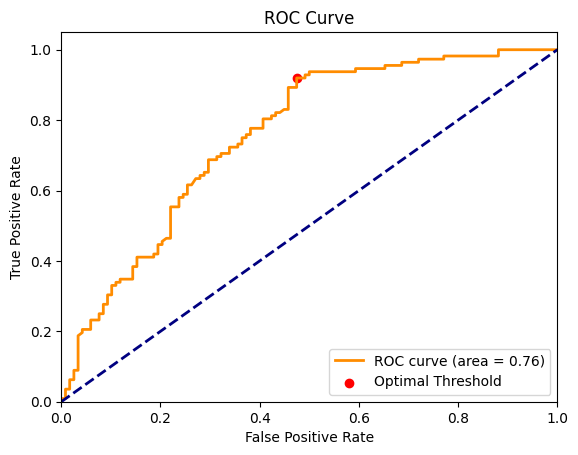

AUC: 0.7563
R2 Efron: 0.19577265689763934
gamma: 0.5 - number of predictions errors: 73 - percentage of correctly classified: 0.6826


In [ ]:
# Predicted probabilities (computed for the test set):
pi_test=M3.predict(X_test)
performancemetrics(y_test,pi_test, 0.5)

M3 Optimal Threshold: 0.3306328451809499
M3 AUC: 0.7563180992736077
y_hat   0    1  All
y                  
0      62   56  118
1      10  102  112
All    72  158  230


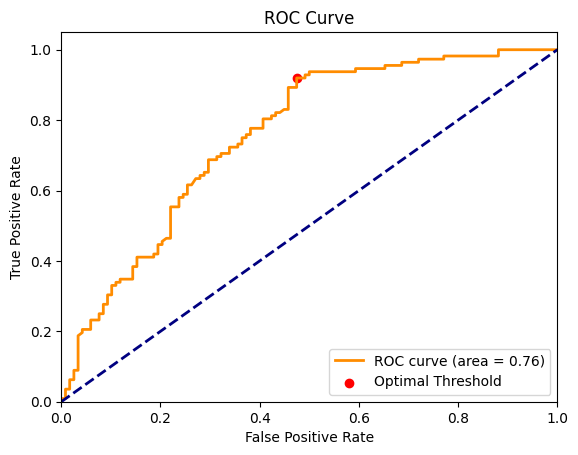

AUC: 0.7563
R2 Efron: 0.19577265689763934
gamma: 0.3306328451809499 - number of predictions errors: 66 - percentage of correctly classified: 0.7130


In [ ]:
 # Compute ROC curve and AUC

fpr, tpr, thresholds = roc_curve(y_test, pi_test)
M3_roc_auc = auc(fpr, tpr)

# Compute the optimal threshold
M3_optimal_idx = np.argmax(tpr - fpr)
M3_gamma = thresholds[M3_optimal_idx]

print(f"{'M3'} Optimal Threshold: {M3_gamma}")
print(f"{'M3'} AUC: {M3_roc_auc}")

def performancemetrics(y_test, pi_test, gamma):
    # Calculate predictions based on gamma threshold
    y_hatnp = np.where(pi_test > gamma, 1, 0)
    y_hat = pd.DataFrame(y_hatnp, columns=['y_hat'])

    # Convert y_test to DataFrame for consistency in handling
    y_laby = pd.DataFrame(y_test).reset_index(drop=True)
    y_laby.columns = ['y']

    # Concatenate true labels and predictions for confusion matrix
    yyhat = pd.concat([y_laby, y_hat], axis=1)

    # Confusion matrix
    confusion_matrix = pd.crosstab(yyhat.y, yyhat.y_hat, margins=True)
    print(confusion_matrix)

    # ROC curve and AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pi_test, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)

    # Find optimal threshold index
    optimal_idx = np.argmax(tpr - fpr)

    # Plotting ROC curve including the optimal threshold
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label='Optimal Threshold')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC
    print('AUC: %.4f' % roc_auc)

    # Calculate and print R2 Efron
    ynp = np.asarray(y_test).ravel()
    pinp = np.asarray(pi_test).ravel()
    R2Efron = 1 - np.sum((ynp - pinp) ** 2) / np.sum((ynp - np.mean(ynp)) ** 2)
    print('R2 Efron:', R2Efron)

    # Calculate and print the number of prediction errors and percentage of correctly classified instances
    nberrors = np.sum((ynp - y_hatnp) ** 2)
    print('gamma:', gamma, '- number of predictions errors:', nberrors, '- percentage of correctly classified: %.4f' % (1 - nberrors / len(ynp)))

performancemetrics(y_test, pi_test, M3_gamma)

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pi_test, pos_label=1)
M3_auc = str(np.round(metrics.auc(fpr, tpr) * 100, 2)) + '%'
M3_aic = np.round(M3.aic,3)
M3_bic = np.round(M3.bic,3)

ynp = np.asarray(y_test).ravel()
pinp = np.asarray(pi_test).ravel()
M3_R2Efron = np.round(1 - np.sum((ynp - pinp) ** 2) / np.sum((ynp - np.mean(ynp)) ** 2), 4)
M3_R2 = str(np.round(M3.prsquared * 100 ,2)) + '%'

# (4). Model Selection Interpretation

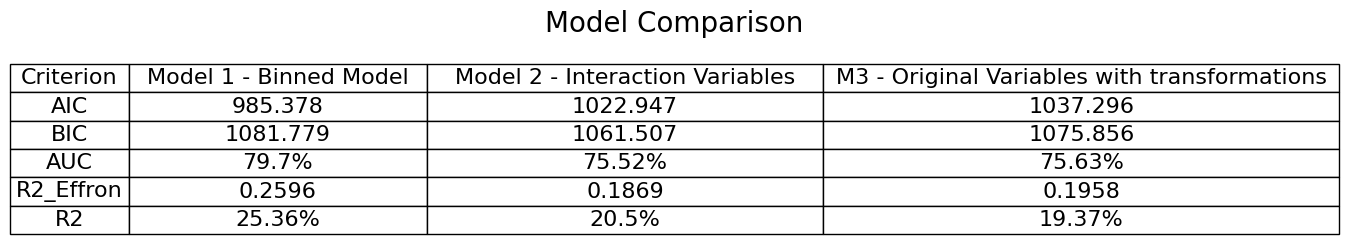

In [ ]:
the_table = [['AIC', M1_aic, M2_aic, M3_aic],
             ['BIC', M1_bic, M2_bic, M3_bic],
             ['AUC', M1_auc, M2_auc, M3_auc],
             ['R2_Effron', M1_R2Efron, M2_R2Efron, M3_R2Efron],
             ['R2', M1_R2, M2_R2, M3_R2]
             ]
the_table=pd.DataFrame(data=the_table)
the_table.columns = ['Criterion', 'Model 1 - Binned Model', 'Model 2 - Interaction Variables', 'M3 - Original Variables with transformations']
plt.subplot(311)
plt.title('Model Comparison',fontsize=20, y=1.5)
plt.axis('off')
plt.axis('tight')
test3=plt.table(cellText=the_table.values, colLabels=the_table.columns, loc='center', cellLoc='center', colWidths=[0.12,0.3,0.4,0.52])
test3.auto_set_font_size(False)
test3.set_fontsize(16)
test3.scale(2, 1.7)

# (5). Interpretation and Prediction


### (a). Re-estimating the best model on the full dataset


In [ ]:
model1_x_data = X_dum_binned_significant_new
model1_y_data = y

final_model = sm.Logit(model1_y_data, model1_x_data).fit()
print(final_model.summary())

Optimization terminated successfully.
         Current function value: 0.521754
         Iterations 6
                              Logit Regression Results                             
Dep. Variable:     binary_job_satisfaction   No. Observations:                 1146
Model:                               Logit   Df Residuals:                     1126
Method:                                MLE   Df Model:                           19
Date:                     Sun, 10 Mar 2024   Pseudo R-squ.:                  0.2458
Time:                             17:37:27   Log-Likelihood:                -597.93
converged:                            True   LL-Null:                       -792.78
Covariance Type:                 nonrobust   LLR p-value:                 6.095e-71
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

### (b). Interpreting Coefficient Signs

In [ ]:
## We will use this reference class dict. to do interpretations

reference_classes_upd

{'allowed_decide_daily_work_organised': 'High',
 'allowed_influence_policy_decisions_activities_organisation': 'High',
 'colleagues_give_workrelated_help_likely': 'Low',
 'communicate_colleagues_work_via_text_email_messaging_apps_often': 'Low',
 'communicate_line_manager_work_via_text_email_messaging_apps_often': 'Medium',
 'current_job_decide_time_start_finish_work': 'Medium',
 'employees_expected_responsive_outside_working_hours_often': 'High',
 'employees_expected_work_overtime_often': 'Very Low',
 'employment_relation': 'Very Low',
 'feeling_households_income_nowadays': 'Low',
 'hampered_daily_activities_illness_disability_infirmity_mental_problem': 'Very High',
 'households_total_net_income_sources': 'Medium',
 'how_emotionally_attached_country': 'Very High',
 'how_happy': 'High',
 'how_many_people_discuss_intimate_personal_matters': 'High',
 'how_often_socially_meet_friends_relatives_colleagues': 'Very High',
 'how_religious': 'Very Low',
 'job_prevents_giving_time_partner_family

1. **βˆhow_emotionally_attached_country_Low:  -0.9976 < 0.**
An individual with a Low emotional attachment to their country is less likely to report job satisfaction than those with Very High attachment level (reference). This suggests that emotional attachment to one's country positively impacts job satisfaction.
2. **βˆhow_emotionally_attached_country_Medium: -0.6159 < 0.**
An individual with Medium emotional attachment to their country is less likely to report job satisfaction than those with Very High attachment level (reference).
3. **βˆhow_happy_Low: -0.9723 < 0.**
Individuals reporting Low happiness levels are less likely to be satisfied with their jobs than those with High happiness levels (reference). This highlights the significant positive effect of happiness on job satisfaction.

4. **βˆhow_happy_Medium: -0.6239 < 0.**
Individuals reporting Medium happiness levels are less likely to be satisfied with their jobs than those with High happiness levels (reference).

5. **βˆhow_happy_Very High: 1.0090 > 0.**
Individuals reporting Very High happiness levels are more likely to be satisfied with their jobs than those with High happiness levels (reference).

6. **βˆline_manager_gives_workrelated_help_likely_Very Low: 0.7100 > 0.**
For this category, the order is inverted. The very low category is actually Very High in the list of options. Individuals whose line manager respond Very High to provide work-related help are more likely to be satisfied with their job than those with who respond High (reference).
7. **βˆline_manager_gives_workrelated_help_likely_High: -0.5431 < 0.**
Individuals whose line manager respond Low to provide work-related help are less likely to be satisfied with their job than those with who respond High (reference).

8. **βˆline_manager_gives_workrelated_help_likely_Very High: -1.2833 < 0.**
Individuals whose line manager respond Very Low to provide work-related help are less likely to be satisfied with their job than those with who respond High (reference).

9. **βˆline_manager_supports_employees_balancing_work_much_Medium: -0.7581 < 0.**
Individuals who receive Medium support from line managers to balance work are less likely to be satisfied with their job, highlighting the importance of support for work-life balance.

10. **βˆnumber_people_living_regularly_member_household_Very Low: -0.3729 < 0.**
Living in a household with very few members regularly decreases the likelihood of job satisfaction, suggesting that personal living arrangements may impact job satisfaction.

11. **βˆpartner_family_fed_pressure_job_often_Very Low: 1.1960 > 0.**
Individuals who rarely feel pressured by their partner or family about their job are more likely to be satisfied with their job than individuals who experience Medium pressure (reference class), indicating the stress from family expectations can negatively impact job satisfaction.

12. **βˆpartner_family_fed_pressure_job_often_Low: 0.8606 > 0.**
Individuals who respond Low in feeling pressured by their partner or family about their job are more likely to be satisfied with their job than individuals who experience Medium pressure (reference class), indicating the stress from family expectations can negatively impact job satisfaction.

13. **βˆtoo_tired_work_enjoy_things_like_home_often_Very High: -1.2955 < 0.** Frequently feeling too tired because of work to enjoy things at home significantly reduces job satisfaction, emphasizing the negative impact of work-related exhaustion on life satisfaction.

14. **βˆdoing_last__days_unemployed_actively_looking_job_0_Not marked: 1.8101 > 0.**
Individuals who did not mark their unemployment status and actively looking for a job in the last days, are more likely to be satisfied with their job than those who didn't mark it (reference class), suggesting a strong negative impact of recent unemployment on job satisfaction.

15. **βˆresponsible_supervising_employees_1_Yes: 0.6336 > 0.** Being responsible for supervising employees increases job satisfaction compared to those who do not supervise others, highlighting the positive aspects of leadership roles.

16. **βˆoccupation_isco_Drivers, Software Developers, and Miscellaneous: -1.3635 < 0.** Individuals in occupations such as drivers, software developers, and other miscellaneous categories are less likely to be satisfied with their jobs, indicating job-specific factors affecting satisfaction.

17. **βˆwhat_type_organisation_work_worked_Miscellaneous: -0.5945 < 0.** Working in miscellaneous types of organizations is associated with lower job satisfaction, compared to reference type of organization work, suggesting organizational factors play a role in job satisfaction.

18. **βˆindustry_nace_rev_Transportation and Miscellaneous: -1.3515 < 0.** Being employed in the transportation industry and miscellaneous sectors is linked to lower job satisfaction, compared to reference sectors, pointing to industry-specific influences.

19. **βˆregion_Northern and Central Regions: 0.3961 > 0**. Living in northern and central regions is associated with a higher probability of job satisfaction, compared to the reference region, indicating regional differences in job satisfaction.



### (c). Odds Ratio

!!ATTENTION: Odds ratio are only OK with the Logit link function!!


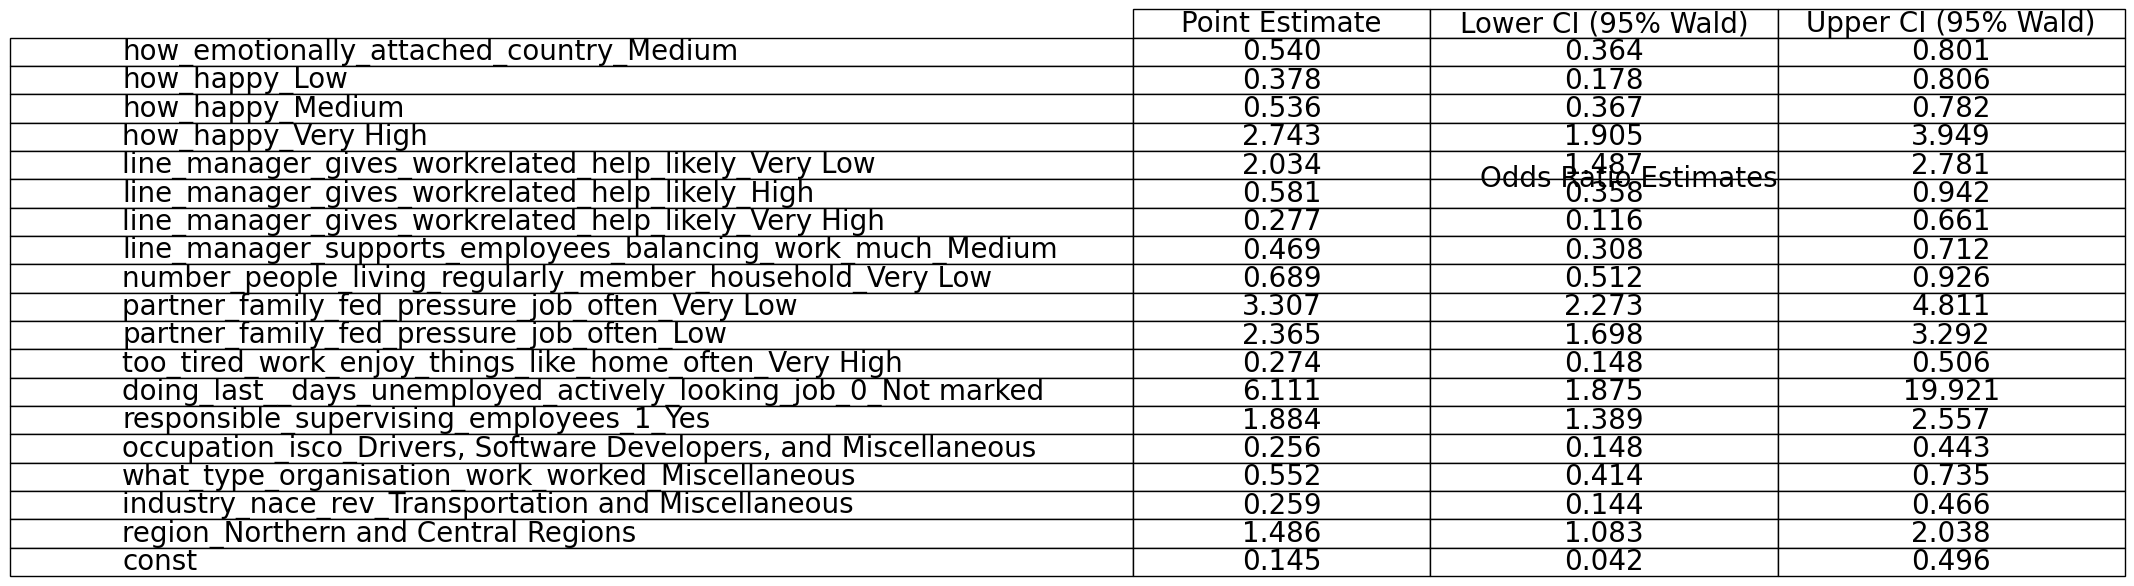

In [ ]:
oddsratioestimates(y,final_model)

Firstly, let's note that all variables are significant. The confidence intervals for all variables do not include 1, which means each variable has a different effect from the reference class.

1. **OR(how_emotionally_attached_country_Medium vs Very High) = 0.54.** An individual who reports Medium attachment to country has odds 0.54 times the odds of an individual who reports Very High (reference).In terms of variation rate: there is a decrease of 46% of the odd
(chance to be satisfied with job rather than not be satisfied) when switching from Very High to Medium attachment.

2. **OR(how_happy_Low vs High) = 0.378.**
An individual who reports Low happiness has odds 0.374 times the odds of an individual who reports High happiness (reference). In terms of variation rate: there is a decrease of 62.2% (chance to be satisfied with job rather than not be satisfied) when switching from High to Low happiness.

3. **OR(how_happy_Medium vs High) = 0.536.**
An individual who reports Medium happinesshas odds 0.536 times the odds of an individual who reports High happiness (reference). In terms of variation rate: there is a decrease of 46.4% (chance to be satisfied with job rather than not be satisfied) when switching from High to Medium happiness.

4. **OR(how_happy_Very High vs High) = 2.743.**
An individual who reports Very High happiness has odds 2.743 times the odds of an individual who reports High happiness (reference). In terms of variation rate: there is an increase of 174.3% (chance to be satisfied with job rather than not be satisfied) when switching from High to Very High happiness.

5. **OR(line_manager_gives_workrelated_help_likely_Very High vs High) = 2.034.**
An individual whose line manager is very likely to give work-related help has odds equal to 2.034 times the odds of an individual whose manager is High to offer workrelated help (reference). In terms of variation rate: there is an increase of 103.4% in the odds of job satisfaction for the switch from High to Very High to get help from a line manager.

6. **OR(line_manager_gives_workrelated_help_likely_Low vs High) = 0.581.**
An individual whose line manager scores Low to give work-related help has odds equal to 0.581 times the odds of an individual whose manager is High to offer workrelated help (reference). In terms of variation rate: there is a decrease of of 41.9% in the odds of job satisfaction for the switch from High to Low to get help from a line manager.

7. **OR(line_manager_gives_workrelated_help_likely_Very_Low vs High) = 0.277.**
An individual whose line manager is scores Very Low to give work-related help has odds equal to 0.277 times the odds of an individual whose manager scores High to offer workrelated help (reference). In terms of variation rate: there is a decrease of 72.3% in the odds of job satisfaction for the switch from High to Very Low to get help from a line manager.

8. **OR(line_manager_supports_employees_balancing_work_much_Medium vs High) = 0.469.**
An individual who receives Medium support from line managers for balancing work has 0.469 times the odds of job satisfaction compared to someone with High support (reference), indicating a 53.1% decrease in the odds of being satisfied with their job if they switch from High to Medium.

9. **OR(number_people_living_regularly_member_household_Very Low vs High) = 0.689.**
Individuals living in households with very few regular members have 0.689 times the odds of being job satisfied compared to those with High members (reference). This shows a decrease of 31.1% in the odds of job satisfaction for the switch from many family members to low family members.

10. **OR(partner_family_fed_pressure_job_often_Very Low vs Medium) = 3.307.**
Individuals who report Very Low to feel job-related pressure from family or partners have 3.307 times the odds of being job satisfied compared to those who report to feel it Medium (reference). There is an increase of 230.7% in the odds of job satisfaction when pressure switches from Medium to Very Low.

11. **OR(partner_family_fed_pressure_job_often_Low vs Medium) = 2.365.**
Individuals who report Low to feel job pressure from family or partners have 2.365 times the odds of being job satisfied compared to individuals who experience it at a Medium frequency (reference). This corresponds to an increase of 136.5% in the odds of being satisfied with their job.

12. **OR(too_tired_work_enjoy_things_like_home_often_Very High vs High) = 0.274.**
Individuals who report Very High in being too tired from work to enjoy things at home have 0.274 times the odds of job satisfaction compared to those who report High (reference). There's a decrease of 72.6% in the odds of job satisfaction if the individual switches from High to Very High.

13. **OR(doing_last__days_unemployed_actively_looking_job_0_Not marked vs Marked) = 6.111.**
Individuals who did not mark themselves as unemployed and actively looking for a job in the last days have 6.111 times the odds of being job satisfied compared to those who did mark themselves as such (reference). The odds of job satisfaction increase by 511.1% if individual switches from marked unemployed to not marked.

14. **OR(responsible_supervising_employees_1_Yes vs No) = 1.884.**
Individuals responsible for supervising employees have 1.884 times the odds of job satisfaction compared to those who aren't supervisors (reference), indicating an 88.4% increase in the odds of job satisfaction when individual switches to have supervisory responsibilities from not having responsibilities.

15. **OR(occupation_isco_Drivers, Software Developers, and Miscellaneous vs Other Occupations) = 0.256.**
Individuals in occupations such as drivers, software developers, and miscellaneous categories have 0.256 times the odds of being job satisfied compared to those in the reference occupations (reference), showing a decrease of 74.4% in the odds of job satisfaction when individual switches from other occupations to drivers...

16. **OR(what_type_organisation_work_worked_Miscellaneous vs Other Types) = 0.552.**
Individuals working in miscellaneous types of organizations have 0.552 times the odds of job satisfaction compared to working in other types of organizations (reference). This reflects a 44.8% decrease in the odds of job satisfaction when the individual switxhes from other types of organisation work to miscellaneous type of work.

17. **OR(industry_nace_rev_Transportation and Miscellaneous vs Other Industries) = 0.259.**
Individuals who are employed in the transportation industry and miscellaneous sectors have 0.259 times the odds of job satisfaction compared to other industries (reference), indicating a decrease of 74.1% in the odds of job satisfaction when the individual switches industries from others to transportation.

18. **OR(region_Northern and Central Regions vs Other Regions) = 1.486.**
Individuals living in northern and central regions have an odd 1.486 times the odds of job satisfaction compared to other regions (reference), representing an increase of 48.6% in the odds of being satisfied with one's job if the individual switches from other regions to northern and central regions.

### (d). Marginal Effect

In [ ]:
ME_byindividual=final_model.get_margeff(at='all', method='dydx',dummy=True)
print(ME_byindividual.margeff[1])

[-0.10444784 -0.07355258 -0.10268921 -0.0743022   0.19506757  0.12810271
 -0.09379185 -0.12186059 -0.08619967 -0.04838531  0.23976688  0.1610341
 -0.26415499  0.14435493  0.07519823 -0.12601481 -0.10409889 -0.12540971
  0.05098828]


**The following interpretations are for individual 1.**

● When the emotional attachment to country changes from Very High to Low, the probability to be job satisfied, compared to not be job satisfied, decreases by 10.44%.

● When the emotional attachment to country changes from Very High to Medium, the probability to be job satisfied, compared to not be job satisfied, decreases by 7.35%.

● When the happiness category changes from High to Low, the probability to be job satisfied, compared to not be job satisfied, decreases by 10.26%.

● When the happiness category changes from High to Medium, the probability to be job satisfied, compared to not be job satisfied, decreases by 7.43%.

● When the happiness category changes from High to Very High, the probability to be job satisfied, compared to not be job satisfied, decreases by 19.5%.

● When the line manager likelihood to give workrelated help changes from High to Very High, the probability to be job satisfied, compared to not be job satisfied increases by 12.81%.

● When the line manager likelihood to give workrelated help changes from High to Low, the probability to be job satisfied, compared to not be job satisfied decreases by 9.37%

● When the line manager likelihood to give workrelated help changes from High to Very Low, the probability to be job satisfied, compared to not be job satisfied decreases by 12.1%

● When the line manager supporting employees balance work changes from High to Medium, the probability to be job satisfied, compared to not be job satisfied decreases by 8.61%

● When the number of people living regularly in the household changes from High to Very Low, the probability to be job satisfied, compared to not be job satisfied decreases by 4.83%.

● When the job pressure fed from partner and family changes from Medium to Very Low, the probability to be job satisfied, compared to not be job satisfied increases by 23.9%.

● When the job pressure fed from partner and family changes from Medium to Low, the probability to be job satisfied, compared to not be job satisfied increases by 16.1%.

● When the frequency to be too tired from work to enjoy things like home changes from High to Very High, the probability to be job satisfied, compared to not be job satisfied, decreases by 26.4%.

● When the status changes from marked as unemployed and actively looking for a job to not marked, the probability to be job satisfied, compared to not be job satisfied, increases by 14.4%.

● When the status changes from not responsible for supervising employees to responsible for supervising employees, the probability to be job satisfied, compared to not be job satisfied, increases by 7.5%.

● When the occupation changes from others(reference) to Drivers and Miscellaneous, the probability to be job satisfied, compared to not be job satisfied, decreases by 12.6%.

● When the type of organisation changes from other (reference) to miscellaneous,  the probability to be job satisfied, compared to not be job satisfied, decreases by 10.4%.

● When the industry changes from other (reference) to Transportation, the probability to be job satisfied, compared to not be job satisfied, decreases by 12.5%.

● When the region changes from other to Northern and Central Regions, the probability to be job satisfied, compared to not be job satisfied, increases by 5%.

### (d). Scorecard

In [ ]:
# Defining the categories with their coefficients, including the reference category

categories = {
    'how_emotionally_attached_country': {
        'Low': -0.9976,
        'Medium': -0.6159,
        'Very High': 0
    },
    'how_happy': {
        'Low': -0.9723,
        'Medium': -0.6239,
        'Very High': 1.0090,
        'High': 0
    },
    'line_manager_gives_workrelated_help_likely': {
        'Very High': 0.7100,
        'Low': -0.5431,
        'Very Low': 0
    },
    'line_manager_supports_employees_balancing_work_much': {
        'Medium': -0.7581,
        'High': 0
    },
    'number_people_living_regularly_member_household': {
        'Very Low': -0.3729,
        'High': 0
    },
    'partner_family_fed_pressure_job_often': {
        'Very Low': 1.1960,
        'Low': 0.8606,
        'Medium': 0.0
    },
    'too_tired_work_enjoy_things_like_home_often': {
        'Very High': -1.2955,
        'High': 0
    },
    'doing_last__days_unemployed_actively_looking_job': {
        'Not marked': 1.8101,
        'Marked': 0
    },
    'responsible_supervising_employees': {
        'Yes': -0.6336,
        'No': 0
    },
    'occupation_isco': {
        'Drivers, Software Developers, and Miscellaneous': 1.3635,
        'Others': 0
    },
    'what_type_organisation_work_worked': {
        'Miscellaneous': 0.5945,
        'Others': 0
    },
    'industry_nace_rev': {
        'Transportation and Miscellaneous': 1.3515,
        'Others': 0
    },
    'region': {
        'Northern and Central Regions': -0.3961,
        'Others': 0
    }
}

categories

{'how_emotionally_attached_country': {'Low': -0.9976,
  'Medium': -0.6159,
  'Very High': 0},
 'how_happy': {'Low': -0.9723,
  'Medium': -0.6239,
  'Very High': 1.009,
  'High': 0},
 'line_manager_gives_workrelated_help_likely': {'Very High': 0.71,
  'Low': -0.5431,
  'Very Low': 0},
 'line_manager_supports_employees_balancing_work_much': {'Medium': -0.7581,
  'High': 0},
 'number_people_living_regularly_member_household': {'Very Low': -0.3729,
  'High': 0},
 'partner_family_fed_pressure_job_often': {'Very Low': 1.196,
  'Low': 0.8606,
  'Medium': 0.0},
 'too_tired_work_enjoy_things_like_home_often': {'Very High': -1.2955,
  'High': 0},
 'doing_last__days_unemployed_actively_looking_job': {'Not marked': 1.8101,
  'Marked': 0},
 'responsible_supervising_employees': {'Yes': -0.6336, 'No': 0},
 'occupation_isco': {'Drivers, Software Developers, and Miscellaneous': 1.3635,
  'Others': 0},
 'what_type_organisation_work_worked': {'Miscellaneous': 0.5945, 'Others': 0},
 'industry_nace_rev': {

In [ ]:
# Step 1: Take the opposite of the estimated coefficients
inverted_categories = {category: {k: -v for k, v in values.items()} for category, values in categories.items()}
inverted_categories

{'how_emotionally_attached_country': {'Low': 0.9976,
  'Medium': 0.6159,
  'Very High': 0},
 'how_happy': {'Low': 0.9723,
  'Medium': 0.6239,
  'Very High': -1.009,
  'High': 0},
 'line_manager_gives_workrelated_help_likely': {'Very High': -0.71,
  'Low': 0.5431,
  'Very Low': 0},
 'line_manager_supports_employees_balancing_work_much': {'Medium': 0.7581,
  'High': 0},
 'number_people_living_regularly_member_household': {'Very Low': 0.3729,
  'High': 0},
 'partner_family_fed_pressure_job_often': {'Very Low': -1.196,
  'Low': -0.8606,
  'Medium': -0.0},
 'too_tired_work_enjoy_things_like_home_often': {'Very High': 1.2955,
  'High': 0},
 'doing_last__days_unemployed_actively_looking_job': {'Not marked': -1.8101,
  'Marked': 0},
 'responsible_supervising_employees': {'Yes': 0.6336, 'No': 0},
 'occupation_isco': {'Drivers, Software Developers, and Miscellaneous': -1.3635,
  'Others': 0},
 'what_type_organisation_work_worked': {'Miscellaneous': -0.5945, 'Others': 0},
 'industry_nace_rev': {'

In [ ]:
# Step 2: Shift the coefficients such that the minimum in a category is 0
shifted_categories = {}
for category, values in inverted_categories.items():
    min_coeff = min(values.values())
    shifted_categories[category] = {k: v - min_coeff for k, v in values.items()}
shifted_categories

{'how_emotionally_attached_country': {'Low': 0.9976,
  'Medium': 0.6159,
  'Very High': 0},
 'how_happy': {'Low': 1.9813,
  'Medium': 1.6328999999999998,
  'Very High': 0.0,
  'High': 1.009},
 'line_manager_gives_workrelated_help_likely': {'Very High': 0.0,
  'Low': 1.2530999999999999,
  'Very Low': 0.71},
 'line_manager_supports_employees_balancing_work_much': {'Medium': 0.7581,
  'High': 0},
 'number_people_living_regularly_member_household': {'Very Low': 0.3729,
  'High': 0},
 'partner_family_fed_pressure_job_often': {'Very Low': 0.0,
  'Low': 0.3353999999999999,
  'Medium': 1.196},
 'too_tired_work_enjoy_things_like_home_often': {'Very High': 1.2955,
  'High': 0},
 'doing_last__days_unemployed_actively_looking_job': {'Not marked': 0.0,
  'Marked': 1.8101},
 'responsible_supervising_employees': {'Yes': 0.6336, 'No': 0},
 'occupation_isco': {'Drivers, Software Developers, and Miscellaneous': 0.0,
  'Others': 1.3635},
 'what_type_organisation_work_worked': {'Miscellaneous': 0.0,
  'Ot

In [ ]:
# Step 3: For each category, take the max of the coefficients and sum them.
# Divide each coefficient by that sum and multiply by 100.

# Taking the max of each category from the shifted categories
max_per_category = {category: max(values.values()) for category, values in shifted_categories.items()}

# Summing the maxes from each category
sum_of_maxes = sum(max_per_category.values())

# Calculating the score for each level in each category by dividing the coefficient by the sum of maxes and multiplying by 100
scorecard = {}
for category, values in shifted_categories.items():
    scorecard[category] = {level: (coeff / sum_of_maxes * 100) if sum_of_maxes else 0
                           for level, coeff in values.items()}

scorecard

{'how_emotionally_attached_country': {'Low': 7.123780688098945,
  'Medium': 4.398091946471672,
  'Very High': 0.0},
 'how_happy': {'Low': 14.14830260357903,
  'Medium': 11.660406461103413,
  'Very High': 0.0,
  'High': 7.205187163484196},
 'line_manager_gives_workrelated_help_likely': {'Very High': 0.0,
  'Low': 8.948285465373683,
  'Very Low': 5.070052414344678},
 'line_manager_supports_employees_balancing_work_much': {'Medium': 5.413530613119296,
  'High': 0.0},
 'number_people_living_regularly_member_household': {'Very Low': 2.6628486553649724,
  'High': 0.0},
 'partner_family_fed_pressure_job_often': {'Very Low': 0.0,
  'Low': 2.3950641968608513,
  'Medium': 8.540538996558077},
 'too_tired_work_enjoy_things_like_home_often': {'Very High': 9.251060426455677,
  'High': 0.0},
 'doing_last__days_unemployed_actively_looking_job': {'Not marked': 0.0,
  'Marked': 12.92577728902155},
 'responsible_supervising_employees': {'Yes': 4.524486210885617, 'No': 0.0},
 'occupation_isco': {'Drivers,

In [ ]:
# Convert the scorecard dictionary to a DataFrame for better visualization
scorecard_df_list = []

for category, scores in scorecard.items():
    for level, score in scores.items():
        scorecard_df_list.append({
            'Category': category.replace('_', ' ').title(),
            'Level': level.replace('_', ' ').title(),
            'Score': round(score, 2)  # Round the score for display purposes
        })

        # Converting the scorecard dictionary directly into a DataFrame
scorecard_table = pd.DataFrame(scorecard_df_list)

# Display the table
scorecard_table = scorecard_table.sort_values(by=['Category', 'Score'], ascending=[True, False])
scorecard_table.reset_index(drop=True, inplace=True)
scorecard_table


Category  \
0    Doing Last  Days Unemployed Actively Looking Job   
1    Doing Last  Days Unemployed Actively Looking Job   
2                    How Emotionally Attached Country   
3                    How Emotionally Attached Country   
4                    How Emotionally Attached Country   
5                                           How Happy   
6                                           How Happy   
7                                           How Happy   
8                                           How Happy   
9                                   Industry Nace Rev   
10                                  Industry Nace Rev   
11         Line Manager Gives Workrelated Help Likely   
12         Line Manager Gives Workrelated Help Likely   
13         Line Manager Gives Workrelated Help Likely   
14  Line Manager Supports Employees Balancing Work...   
15  Line Manager Supports Employees Balancing Work...   
16    Number People Living Regularly Member Household   
17    Number People Living Regularly Member Household   
18                                    Occupation Isco   
19                                    Occupation Isco   
20              Partner Family Fed Pressure Job Often   
21              Partner Family Fed Pressure Job Often   
22              Partner Family Fed Pressure Job Often   
23                                             Region   
24                                             Region   
25                  Responsible Supervising Employees   
26                  Responsible Supervising Employees   
27        Too Tired Work Enjoy Things Like Home Often   
28        Too Tired Work Enjoy Things Like Home Often   
29                 What Type Organisation Work Worked   
30                 What Type Organisation Work Worked   

                                              Level  Score  
0                                            Marked  12.93  
1                                        Not Marked   0.00  
2                                               Low   7.12  
3                                            Medium   4.40  
4                                         Very High   0.00  
5                                               Low  14.15  
6                                            Medium  11.66  
7                                              High   7.21  
8                                         Very High   0.00  
9                                            Others   9.65  
10                 Transportation And Miscellaneous   0.00  
11                                              Low   8.95  
12                                         Very Low   5.07  
13                                        Very High   0.00  
14                                           Medium   5.41  
15                                             High   0.00  
16                                         Very Low   2.66  
17                                             High   0.00  
18                                           Others   9.74  
19  Drivers, Software Developers, And Miscellaneous   0.00  
20                                           Medium   8.54  
21                                              Low   2.40  
22                                         Very Low   0.00  
23                     Northern And Central Regions   2.83  
24                                           Others   0.00  
25                                              Yes   4.52  
26                                               No   0.00  
27                                        Very High   9.25  
28                                             High   0.00  
29                                           Others   4.25  
30                                    Miscellaneous   0.00

The scorecard translates logistic regression coefficients into a points system, with each category and level being assigned a score reflecting its impact on job satisfaction. Higher scores indicate attributes more strongly associated with being unsatisfied at work, while lower scores mean satisfied at job.